# 1C 96-well plates growth curve analysis

## Import packages

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import SpanSelector
from datetime import datetime
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

## Input parameters

In [183]:
#FILE INPUT
plate_data_directory = '/Users/thibaultrosazza/Documents/Python/Data/GrowthCurve_global/Aj/BAMixAj1.csv'
condition_data_directory = '/Users/thibaultrosazza/Documents/Python/Data/GrowthCurve_global/Aj/BAMixAj1_WellID.csv'

#RESULT OUTPUT
results_output_directory = '/Users/thibaultrosazza/Documents/Python/Results/Growth_curve_global/Aj/'

#CONDITION TESTED
condition_1 = 'BAMix1'

#SMOOTHING PARAMETER
smoothSize = 25

#TIME INTERVAL
dT=5

## Import data

In [184]:
plate_raw_data = pd.read_csv(plate_data_directory)
plate_raw_data.head()

Time  T° 600     A1     A2     A3     A4    A5     A6     A7     A8  \
0  0:04:16    30.0  0.081  0.081  0.081  0.085  0.08  0.081  0.081  0.079   
1  0:09:16    30.1  0.081  0.081  0.081  0.085  0.08  0.080  0.081  0.079   
2  0:14:16    30.1  0.081  0.081  0.081  0.085  0.08  0.081  0.081  0.079   
3  0:19:16    30.1  0.081  0.081  0.082  0.085  0.08  0.081  0.081  0.079   
4  0:24:16    30.1  0.081  0.081  0.081  0.085  0.08  0.080  0.081  0.080   

   ...     H3     H4    H5     H6     H7     H8     H9    H10    H11    H12  
0  ...  0.081  0.082  0.08  0.082  0.081  0.082  0.084  0.082  0.081  0.086  
1  ...  0.081  0.082  0.08  0.082  0.081  0.082  0.084  0.082  0.081  0.086  
2  ...  0.081  0.082  0.08  0.082  0.081  0.082  0.084  0.082  0.081  0.086  
3  ...  0.081  0.082  0.08  0.082  0.081  0.082  0.084  0.082  0.081  0.086  
4  ...  0.081  0.081  0.08  0.082  0.081  0.082  0.084  0.082  0.081  0.086  

[5 rows x 98 columns]

In [185]:
#RENAME COLUMN NAME BASED ON THE EXPERIMENT DESIGN
experiment_conditions = pd.read_csv(condition_data_directory, header=None, names=['Well','Condition'])
experiment_conditions_dict = pd.Series(experiment_conditions.Condition.values,index=experiment_conditions.Well).to_dict()
plate_data = plate_raw_data.rename(columns=experiment_conditions_dict)
plate_data.head()

Time  T° 600  Control_1  Control_2  Control_3  Control_4  Control_5  \
0  0:04:16    30.0      0.081      0.081      0.081      0.085       0.08   
1  0:09:16    30.1      0.081      0.081      0.081      0.085       0.08   
2  0:14:16    30.1      0.081      0.081      0.081      0.085       0.08   
3  0:19:16    30.1      0.081      0.081      0.082      0.085       0.08   
4  0:24:16    30.1      0.081      0.081      0.081      0.085       0.08   

   Control_6  Control_7  Control_8  ...  Control_27  Control_28  Control_29  \
0      0.081      0.081      0.079  ...       0.081       0.082        0.08   
1      0.080      0.081      0.079  ...       0.081       0.082        0.08   
2      0.081      0.081      0.079  ...       0.081       0.082        0.08   
3      0.081      0.081      0.079  ...       0.081       0.082        0.08   
4      0.080      0.081      0.080  ...       0.081       0.081        0.08   

   Control_30  Control_31  Control_32  Control_33  Control_34  Control_35  \
0       0.082       0.081       0.082       0.084       0.082       0.081   
1       0.082       0.081       0.082       0.084       0.082       0.081   
2       0.082       0.081       0.082       0.084       0.082       0.081   
3       0.082       0.081       0.082       0.084       0.082       0.081   
4       0.082       0.081       0.082       0.084       0.082       0.081   

   Control_36  
0       0.086  
1       0.086  
2       0.086  
3       0.086  
4       0.086  

[5 rows x 98 columns]

In [186]:
#TRANSFORM TIME INTO NUMERICAL VALUE (REFERENCE = HOURS)

Time_hour = []

for index, row in plate_data.iterrows():
    time_string=plate_data.loc[index,'Time']
    hours, minutes, seconds = map(int, time_string.split(':'))
    total_hours = hours + minutes / 60 + seconds / 3600
    Time_hour.append(total_hours)
    
plate_data['Time_hours'] = Time_hour
plate_data.head()

Time  T° 600  Control_1  Control_2  Control_3  Control_4  Control_5  \
0  0:04:16    30.0      0.081      0.081      0.081      0.085       0.08   
1  0:09:16    30.1      0.081      0.081      0.081      0.085       0.08   
2  0:14:16    30.1      0.081      0.081      0.081      0.085       0.08   
3  0:19:16    30.1      0.081      0.081      0.082      0.085       0.08   
4  0:24:16    30.1      0.081      0.081      0.081      0.085       0.08   

   Control_6  Control_7  Control_8  ...  Control_28  Control_29  Control_30  \
0      0.081      0.081      0.079  ...       0.082        0.08       0.082   
1      0.080      0.081      0.079  ...       0.082        0.08       0.082   
2      0.081      0.081      0.079  ...       0.082        0.08       0.082   
3      0.081      0.081      0.079  ...       0.082        0.08       0.082   
4      0.080      0.081      0.080  ...       0.081        0.08       0.082   

   Control_31  Control_32  Control_33  Control_34  Control_35  Control_36  \
0       0.081       0.082       0.084       0.082       0.081       0.086   
1       0.081       0.082       0.084       0.082       0.081       0.086   
2       0.081       0.082       0.084       0.082       0.081       0.086   
3       0.081       0.082       0.084       0.082       0.081       0.086   
4       0.081       0.082       0.084       0.082       0.081       0.086   

   Time_hours  
0    0.071111  
1    0.154444  
2    0.237778  
3    0.321111  
4    0.404444  

[5 rows x 99 columns]

## Quality control

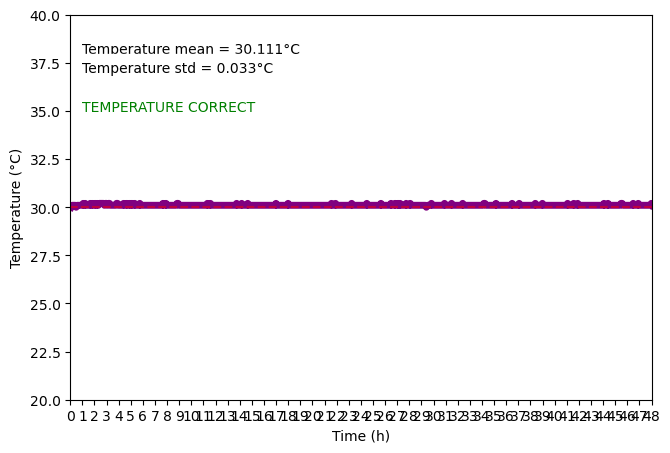

In [187]:
#CHECKING THAT THE TEMPERATURE REMAINED CONSTANT OVER TIME
%matplotlib inline

Temp_mean = round(plate_data['T° 600'].mean(), 3)
Temp_std = round(plate_data['T° 600'].std(), 3)


fig, axs = plt.subplots(1, 1, figsize=(7.5,5))
plt.plot(plate_data['Time_hours'],plate_data['T° 600'], color='purple', linewidth=5)
plt.axhline(y=30, color='red', linestyle='--', label='Threshold', alpha=0.5)

plt.xticks(range(49))
plt.xlim(0,48)
plt.xlabel('Time (h)')

plt.ylim(20,40)
plt.ylabel('Temperature (°C)')

plt.text(1, 38, 'Temperature mean = '+str(Temp_mean)+'°C', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))
plt.text(1, 37, 'Temperature std = '+str(Temp_std)+'°C', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

if Temp_mean >= 32 or Temp_mean <= 29:
    plt.text(1, 35, 'TEMPERATURE ERROR', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'), color='Red')
elif Temp_std >= 1:
    plt.text(1, 35, 'TEMPERATURE ERROR', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'), color='Red')
else:
    plt.text(1, 35, 'TEMPERATURE CORRECT', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'), color='Green')

plt.show()

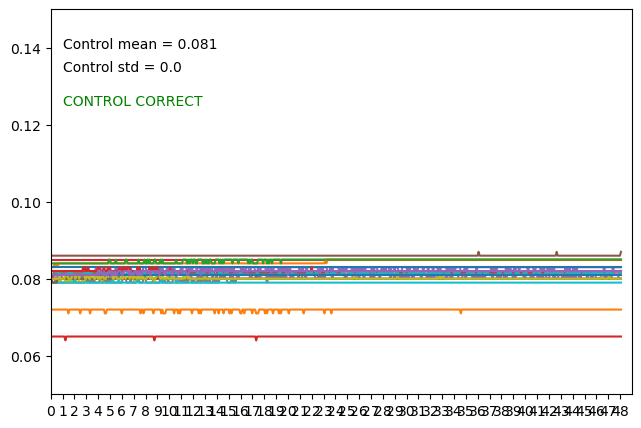

In [188]:
#CHECKING THE CONTROLS
%matplotlib inline

Control_mean_v = []
Control_std_v = []

fig, axs = plt.subplots(1, 1, figsize=(7.5,5))

for column in plate_data.columns:
    if 'Control_' in column:
        plt.plot(plate_data['Time_hours'], plate_data[column], label=column)
        Control_mean_v.append(plate_data[column].mean())
        Control_std_v.append(plate_data[column].std())
        
        
Control_mean = round(np.mean(Control_mean_v), 3)
Control_std = round(np.std(Control_std_v), 3)

plt.ylim(0.05,0.15)

plt.text(1, 0.14, 'Control mean = '+str(Control_mean), bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))
plt.text(1, 0.134, 'Control std = '+str(Control_std), bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

if Control_mean >= 0.1:
    plt.text(1, 0.125, 'CONTROL ERROR', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'), color='Red')
elif Control_std >= 0.02:
    plt.text(1, 0.125, 'CONTROL ERROR', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'), color='Red')
else:
    plt.text(1, 0.125, 'CONTROL CORRECT', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'), color='Green')

plt.xticks(range(49))
plt.xlim(0,49)

plt.show()

## Data visualization

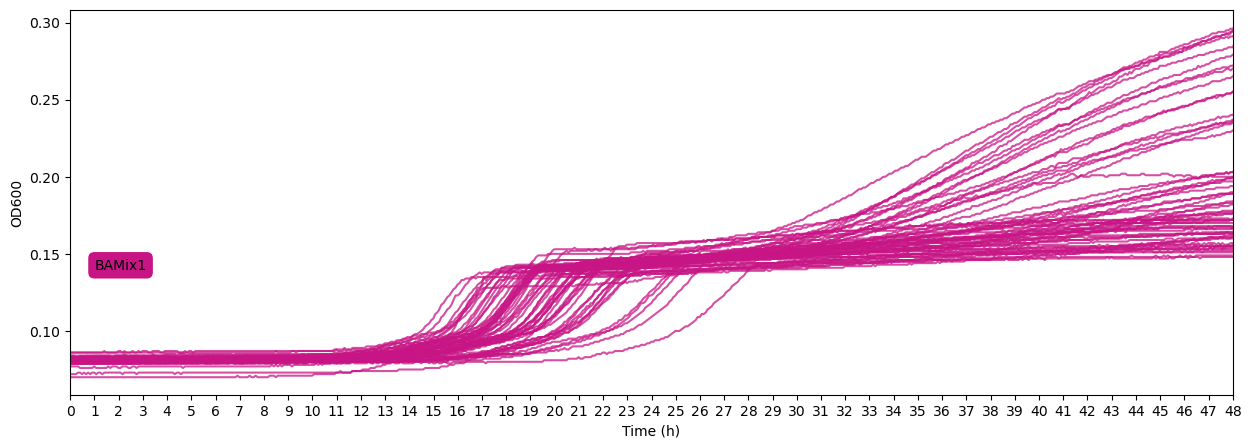

In [189]:
#QUICK VISUALISATION OF ALL GROWTH CURVE
%matplotlib inline

fig, axes = plt.subplots(1, 1, figsize=(15,5))

for column in plate_data.columns:
    if condition_1 in column:
        plt.plot(plate_data['Time_hours'], plate_data[column], label=column, color='mediumvioletred', alpha=0.75)
        plt.text(1, 0.14, condition_1, bbox=dict(facecolor='mediumvioletred', edgecolor='white', boxstyle='round,pad=0.5'))
    
#plt.ylim(0.075,0.15)
plt.xlim(0,48)
plt.ylabel('OD600')
plt.xlabel('Time (h)')
plt.xticks(range(49))

plt.show()

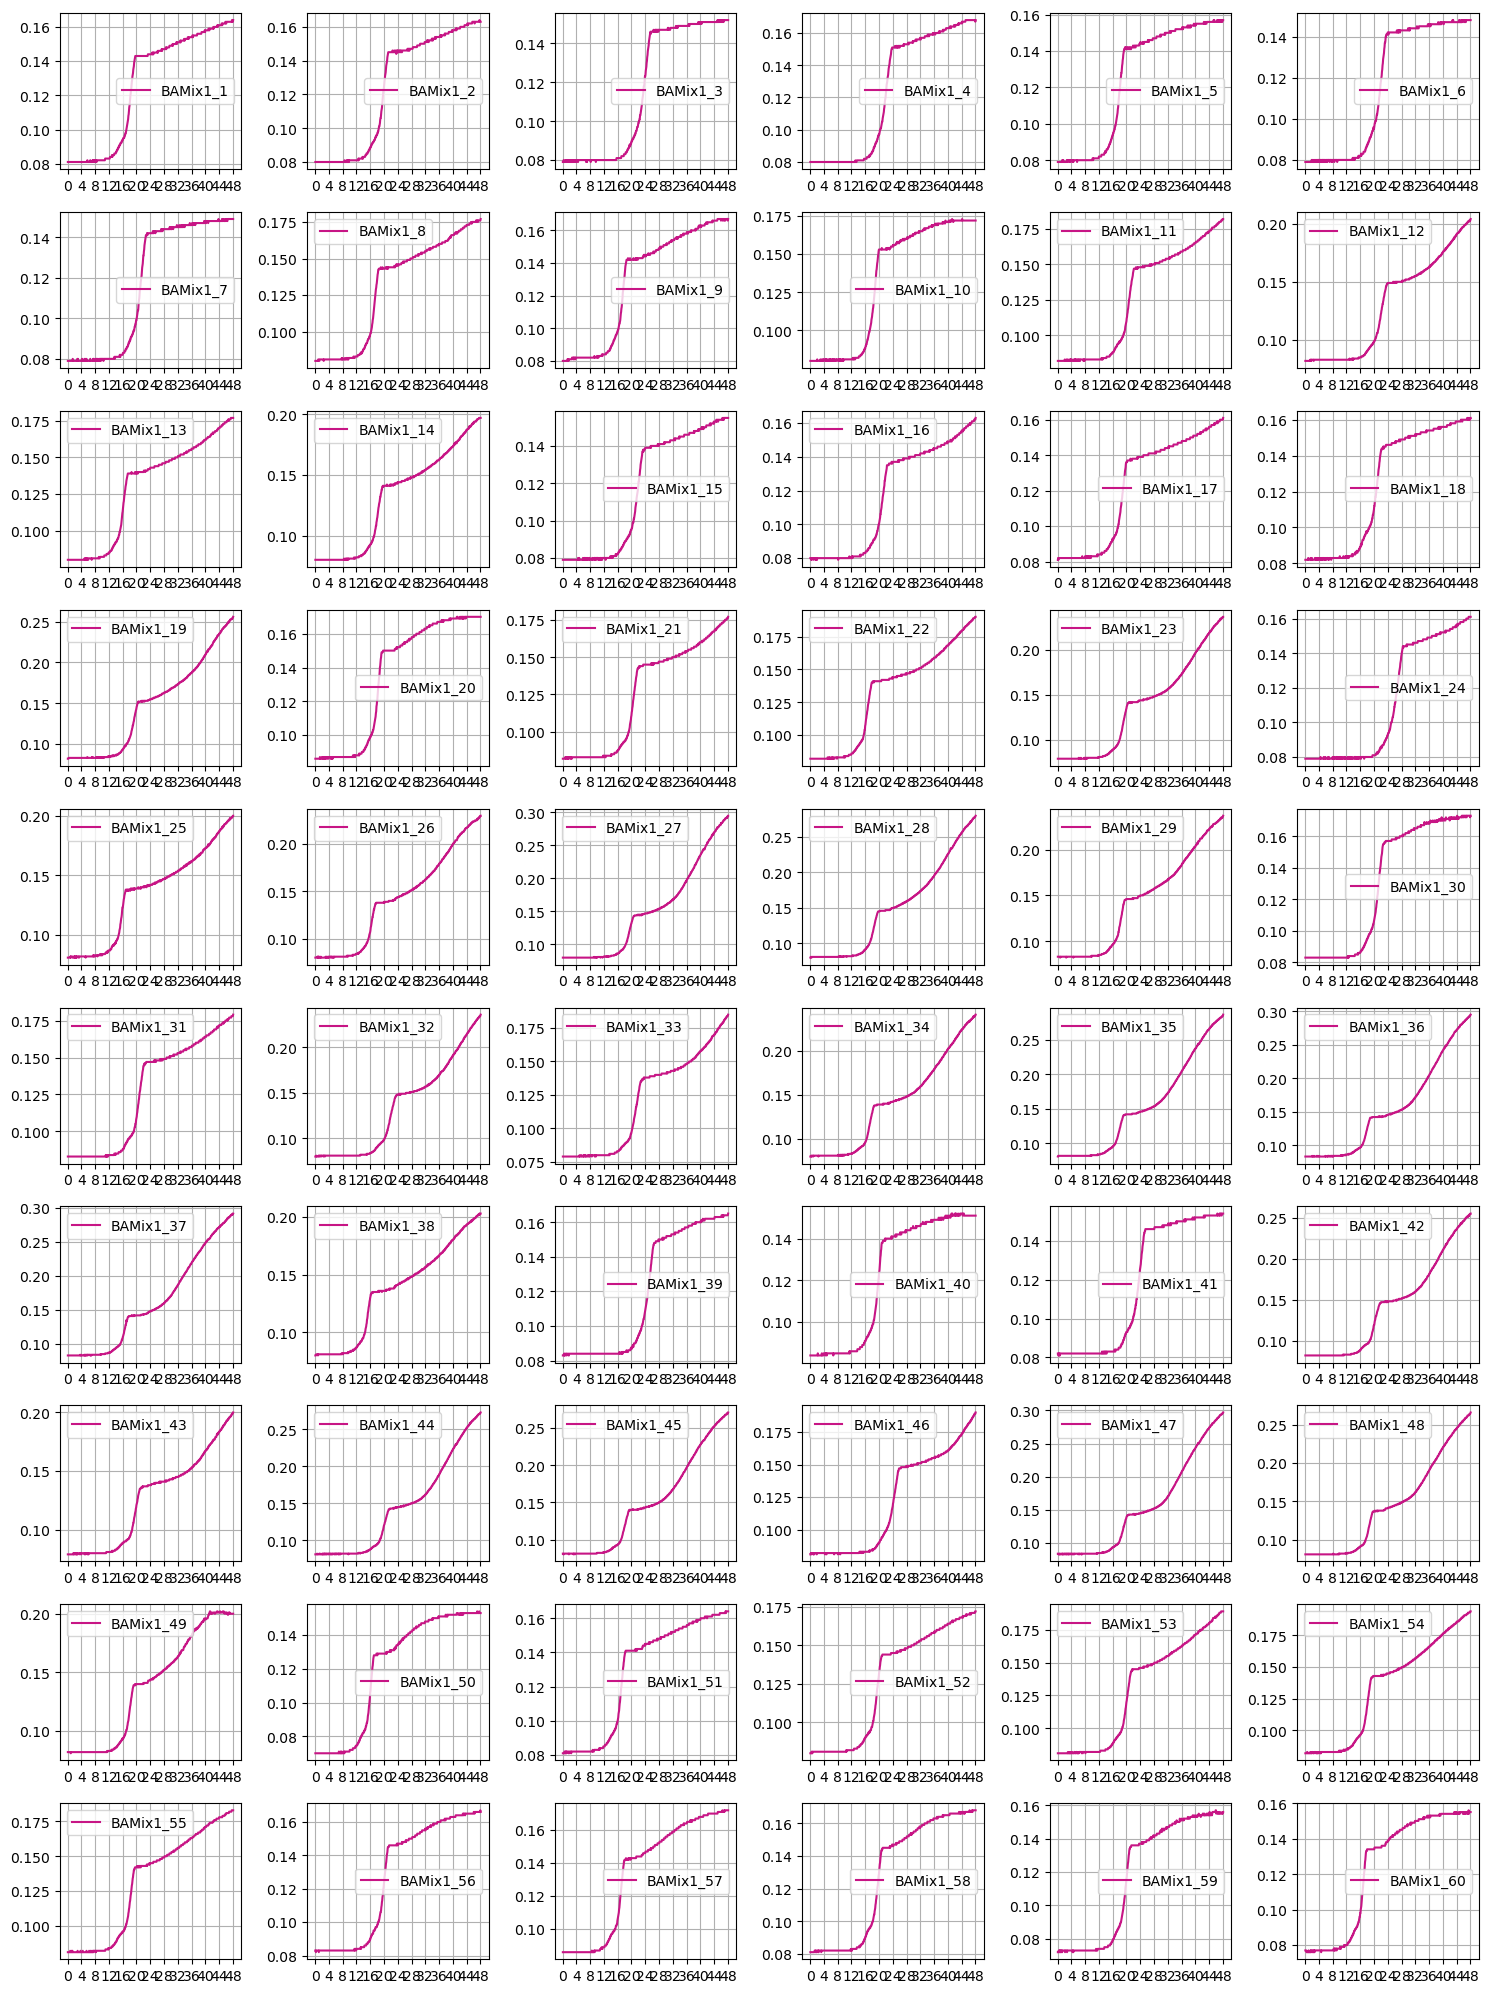

In [190]:
df = plate_data.filter(like=condition_1, axis=1)

# Plotting
num_graphs = len(df.columns)
graphs_per_row = 6
graphs_per_column = 5

# Calculate the number of rows needed
num_rows = int(np.ceil(num_graphs / graphs_per_row))

# Create subplots
fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 20))  # Adjust the figure size as needed

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Iterate over each graph
for i in range(num_graphs):
    ax = axes[i]
    ax.plot(plate_data['Time_hours'], df.iloc[:, i], label=df.columns[i], color='mediumvioletred')
    #ax.set_title(f'Graph_{i + 1}')
    #ax.set_xlabel('X-axis label')
    #ax.set_ylabel('Y-axis label')
    ax.set_xticks(np.arange(0, 49, 4))
    #ax.set_ylim(0.07,0.15)
    ax.legend()
    ax.grid(True)

# Remove empty subplots (if any)
for j in range(num_graphs, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Quantification of growth parameters

<p><strong>To select the growth time frame, click on the smoothed red growth curve.<br>
<strong>Select first a start point and then an end point.<br>
<strong>To skip the growth curve and move to the next one double click.</strong></p>

If you select a time point not on the smoothed red growth curve you will not be able calculate growth parameters.

In [191]:
#SELECTING THE GROWTH TIME FRAME
%matplotlib qt

background = Control_mean
Condition_1 = plate_data.filter(like=condition_1, axis=1)

# Get the list of columns
Condition_1_columns = Condition_1.columns[0:]

Condition_1_dict = {}
# Iterate over each column
for Condition_1_col in Condition_1_columns:
    # Create a new DataFrame with 'Time' and the current column
    subset_df = plate_data[['Time_hours', Condition_1_col]].copy()
    
    # Set the column as the key in the dictionary
    Condition_1_dict[Condition_1_col] = subset_df
   
#Iterate over each key in the dictionary    
for i in Condition_1_columns:
    chosen_key = i
    # Get the DataFrame corresponding the chosen key
    chosen_df = Condition_1_dict[chosen_key]
    
    # Calculate the moving average
    chosen_df['Smoothed'] = chosen_df[chosen_key].rolling(window=smoothSize).mean()
    
    # Create a new figure for each iteration
    plt.figure()
    # Plot the data and the smooth curve
    plt.plot(chosen_df['Time_hours'], chosen_df[chosen_key], marker='o', linestyle='-', color='dimgrey', label=chosen_key)
    plt.plot(chosen_df['Time_hours'], chosen_df['Smoothed'], marker='', linestyle='-', color='red', linewidth=2.5)
    plt.xlabel('Time')
    plt.ylabel(chosen_key)
    plt.title(f'{chosen_key}')
    plt.legend('', frameon=False)
    plt.show()

    # Get two x-values from user clicks
    x_values = plt.ginput(2)
    plt.close()

    # Extract x1 and x2 values
    x1, x2 = [x[0] for x in x_values]
    
    # Check if the time range is greater than or equal to 1 hour
    time_range = x2 - x1
    if time_range < 1.0:
        # Delete filtered_df if the time range is smaller than 1 hour
        print(f"Time range is less than 1 hour. Deleting {chosen_key}.")
        Condition_1_dict.pop(chosen_key, None)
        # Display selected x-values
        print(f"{chosen_key} has been removed from dataset")
    else:
        # Filter the DataFrame based on the selected time range
        filtered_df = chosen_df[(chosen_df['Time_hours'] >= x1) & (chosen_df['Time_hours'] <= x2)]
        Condition_1_dict[chosen_key] = filtered_df
        # Display selected x-values
        print(f"{chosen_key} x1: {x1}, x2: {x2}")

BAMix1_1 x1: 4.484014336917564, x2: 27.79691756272402
BAMix1_2 x1: 6.187240143369177, x2: 29.81949820788531
BAMix1_3 x1: 9.593691756272406, x2: 35.567885304659505
BAMix1_4 x1: 8.848530465949825, x2: 33.43885304659499
BAMix1_5 x1: 6.080788530465952, x2: 32.26788530465951
BAMix1_6 x1: 8.529175627240146, x2: 35.461433691756284
BAMix1_7 x1: 7.67756272401434, x2: 35.142078853046606
BAMix1_8 x1: 6.40014336917563, x2: 24.603369175627243
BAMix1_9 x1: 7.0388530465949835, x2: 30.458207885304667
BAMix1_10 x1: 7.464659498207887, x2: 44.296917562724026
BAMix1_11 x1: 6.61304659498208, x2: 30.671111111111117
BAMix1_12 x1: 8.848530465949825, x2: 31.8420788530466
BAMix1_13 x1: 6.40014336917563, x2: 30.032401433691767
BAMix1_14 x1: 7.67756272401434, x2: 29.60659498207886
BAMix1_15 x1: 7.784014336917565, x2: 34.2904659498208
BAMix1_16 x1: 9.487240143369178, x2: 32.587240143369186
BAMix1_17 x1: 6.9324014336917585, x2: 31.94853046594983
BAMix1_18 x1: 7.251756272401437, x2: 33.43885304659499
BAMix1_19 x1: 8

Condition     Yield  Max Growth Rate  Half Saturation Constant  \
0  BAMix1_1  0.108267          0.01776                  0.015687   
1  BAMix1_2  0.112933          0.01824                  0.016896   
2  BAMix1_3  0.115133          0.01584                  0.017867   
3  BAMix1_4  0.127933          0.01728                  0.021315   
4  BAMix1_5  0.116067          0.01776                  0.036540   

   Max Uptake Rate  
0         0.031416  
1         0.032158  
2         0.030857  
3         0.031147  
4         0.032336

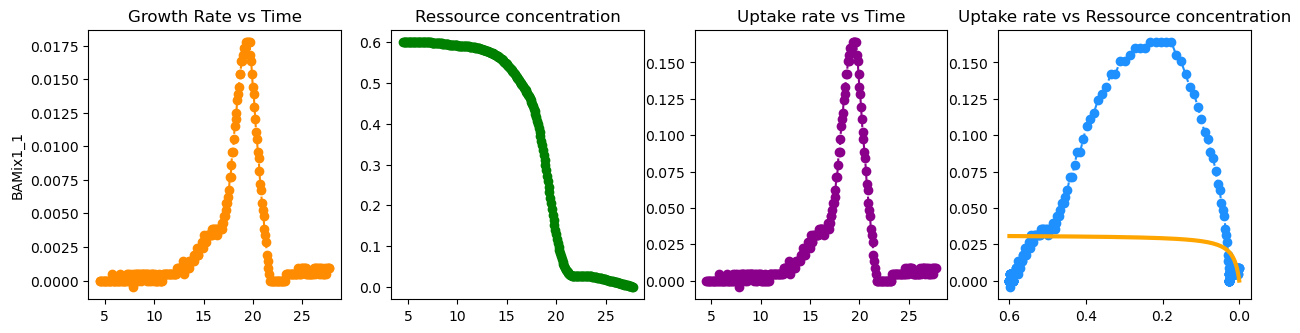

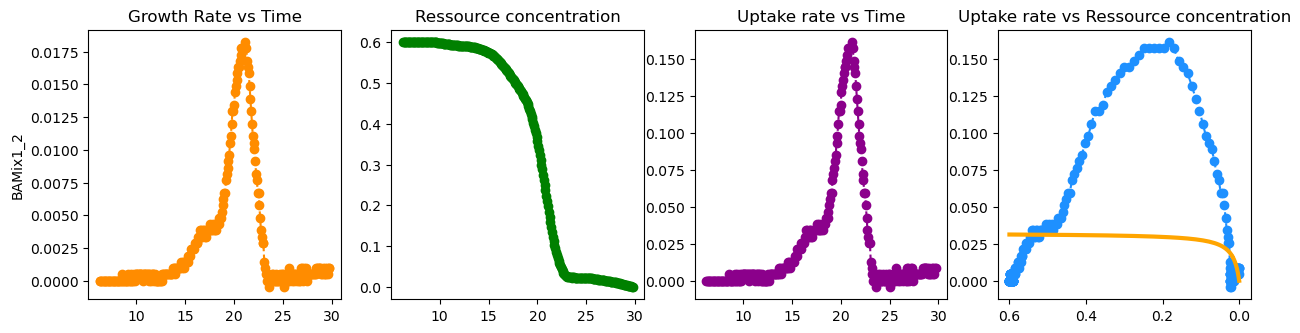

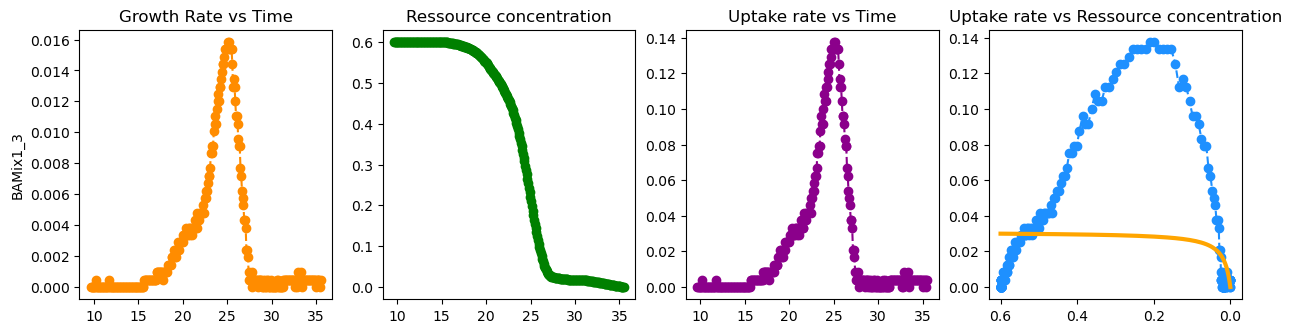

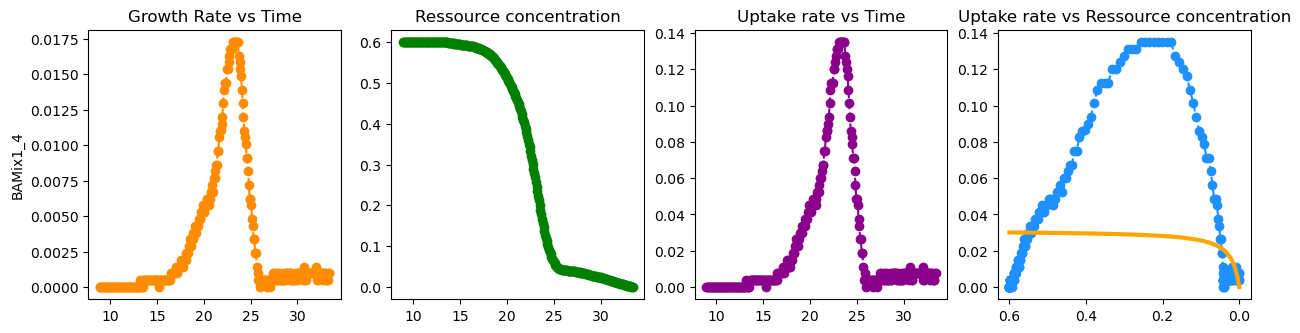

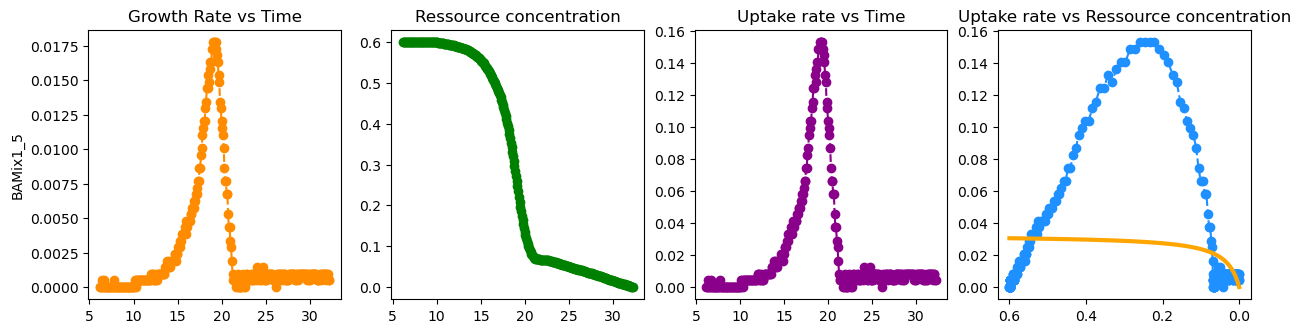

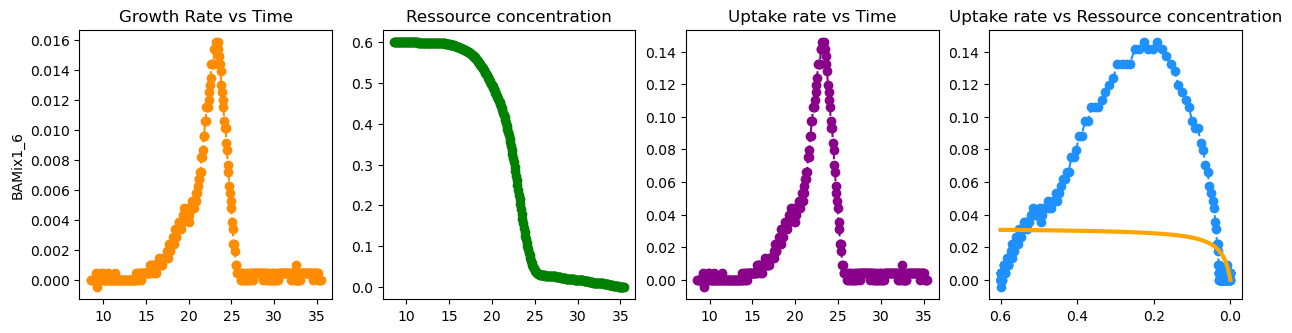

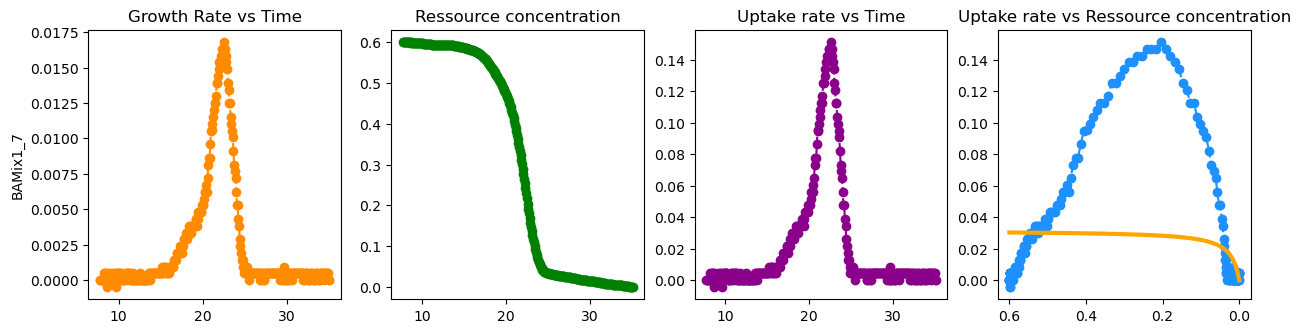

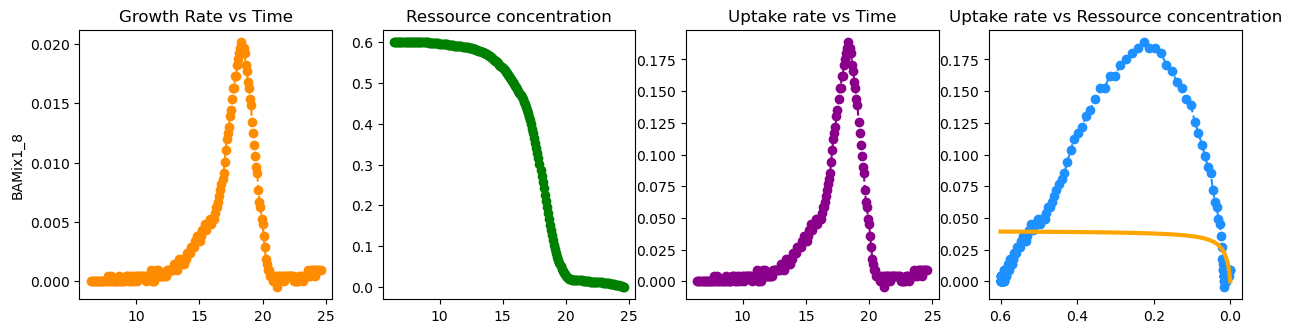

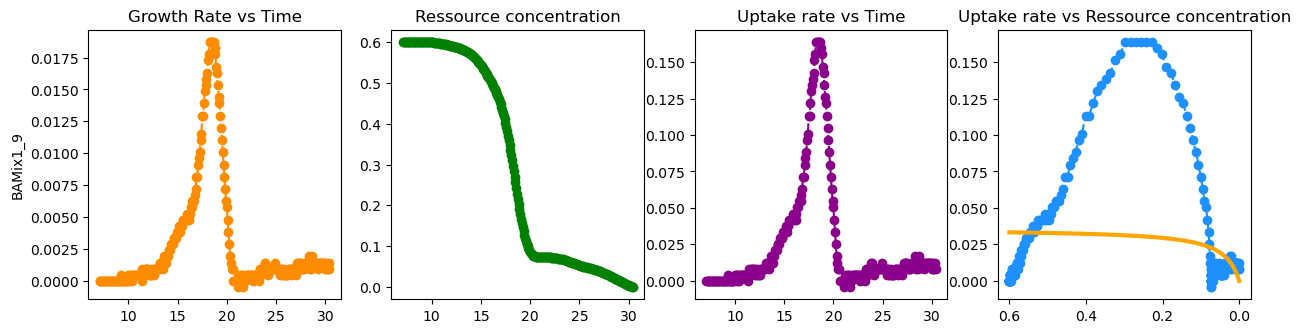

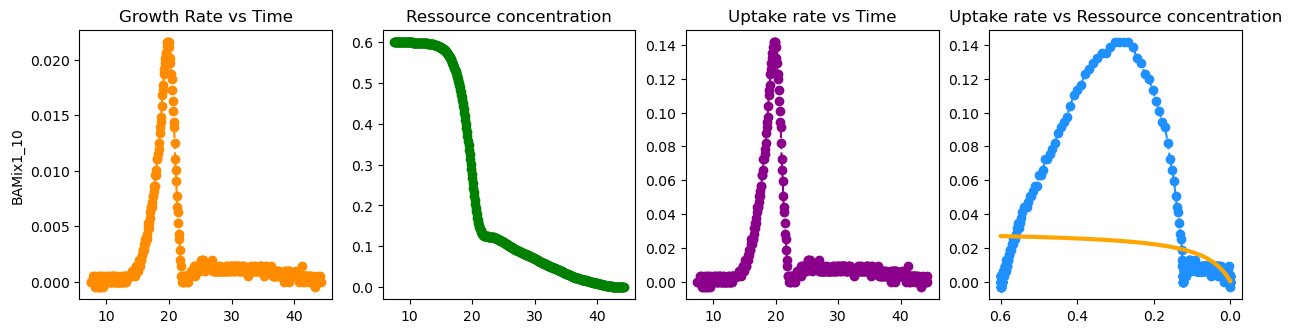

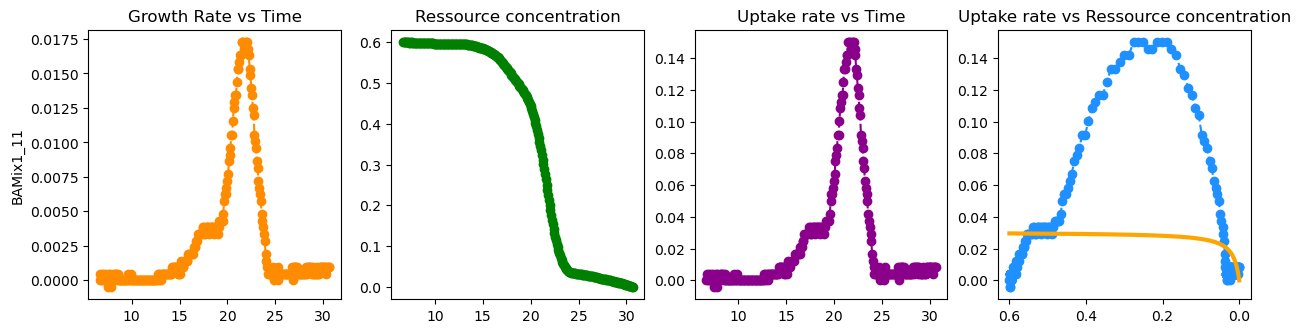

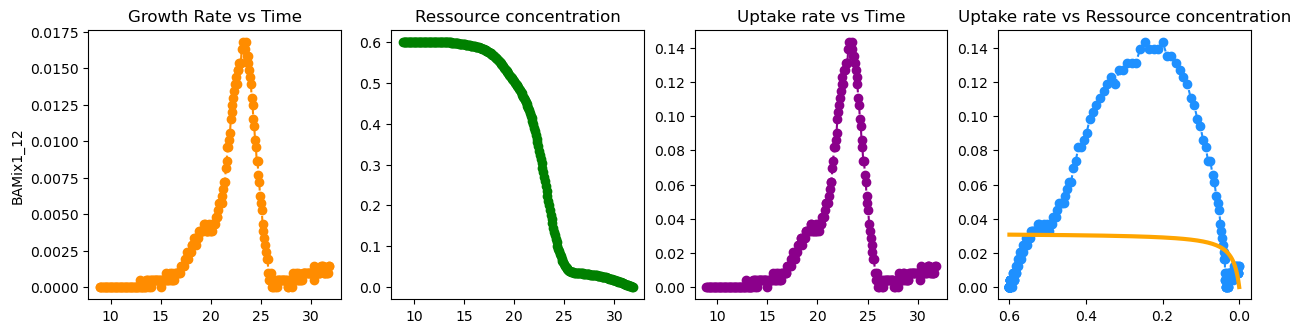

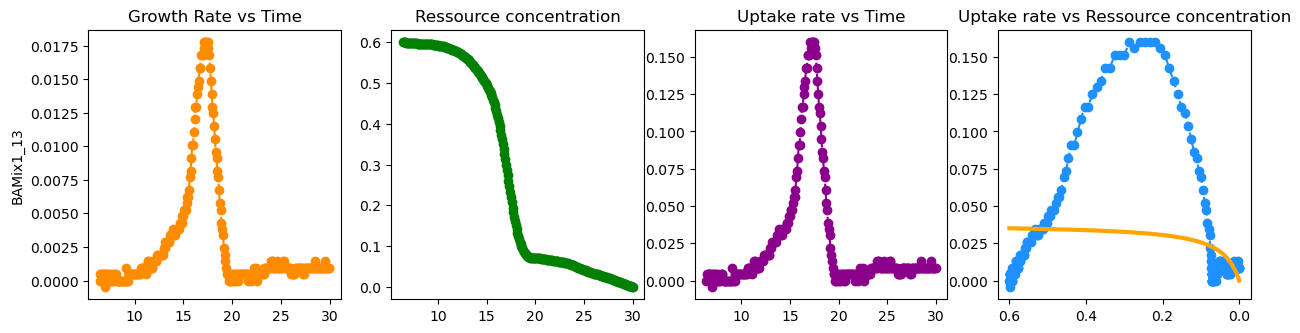

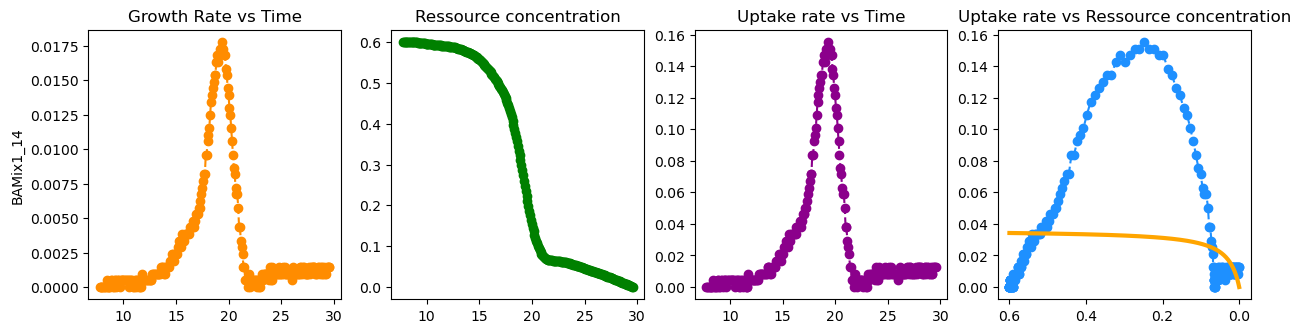

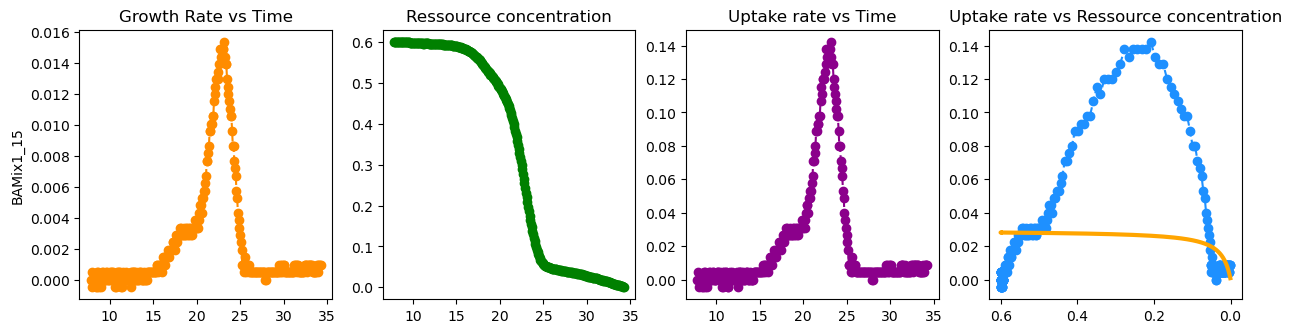

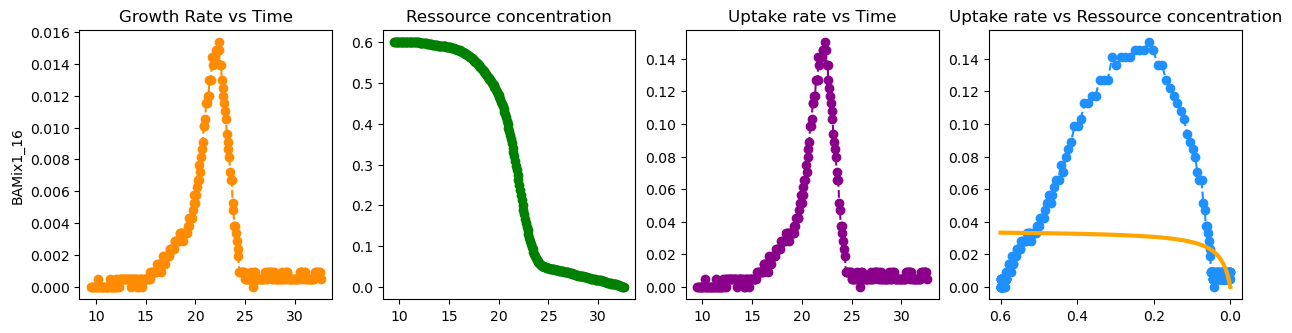

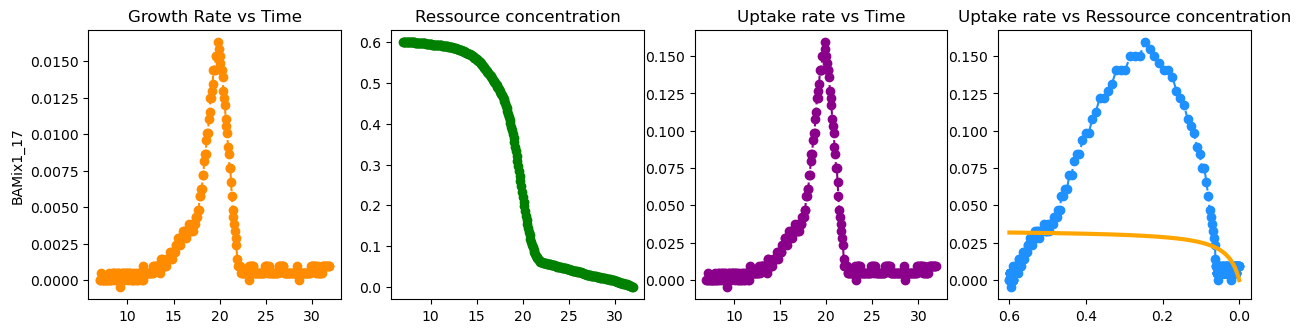

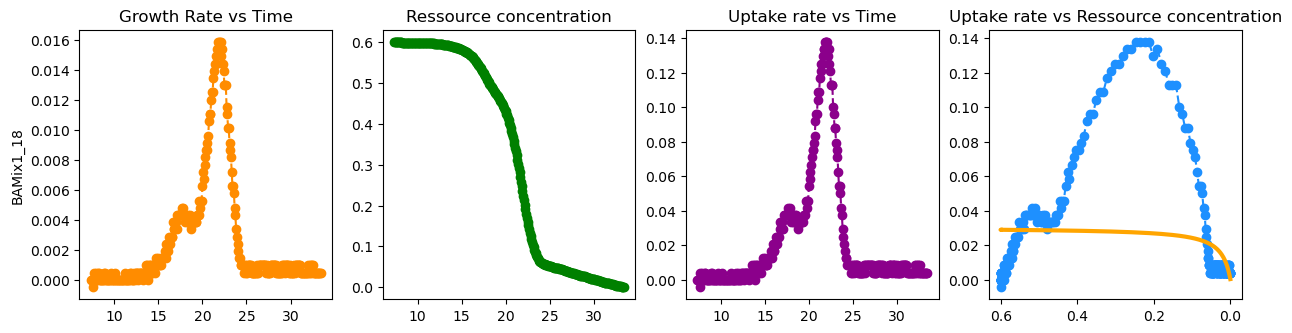

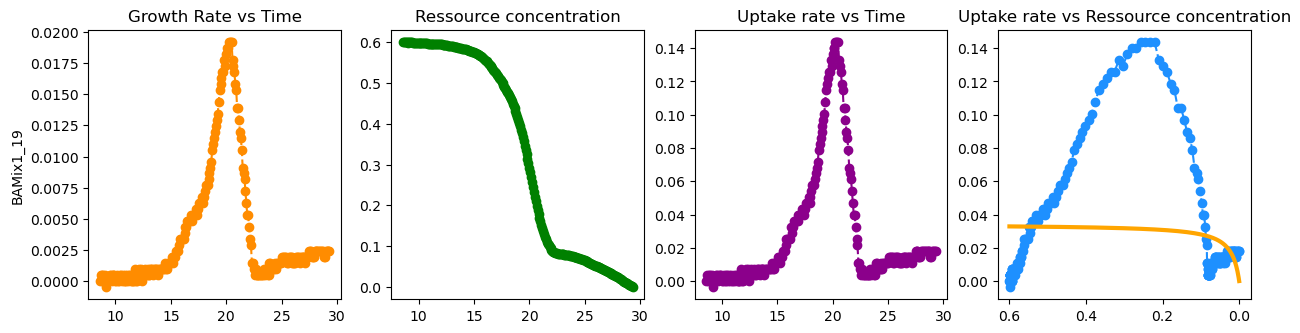

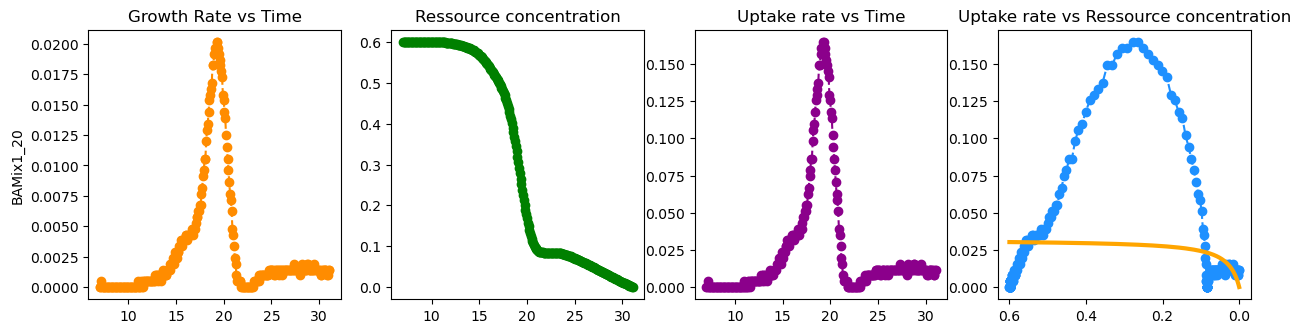

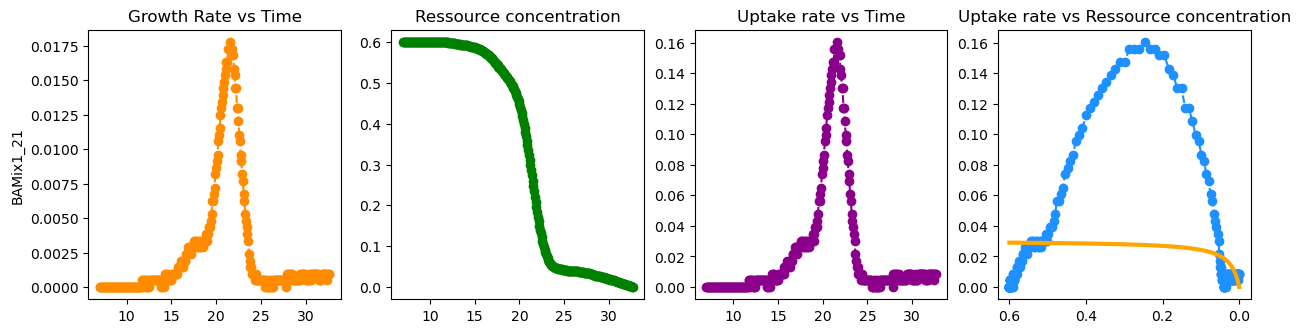

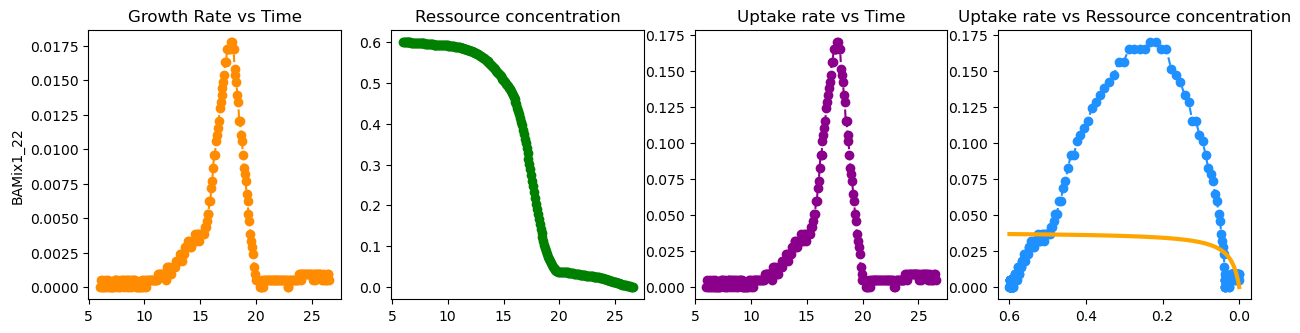

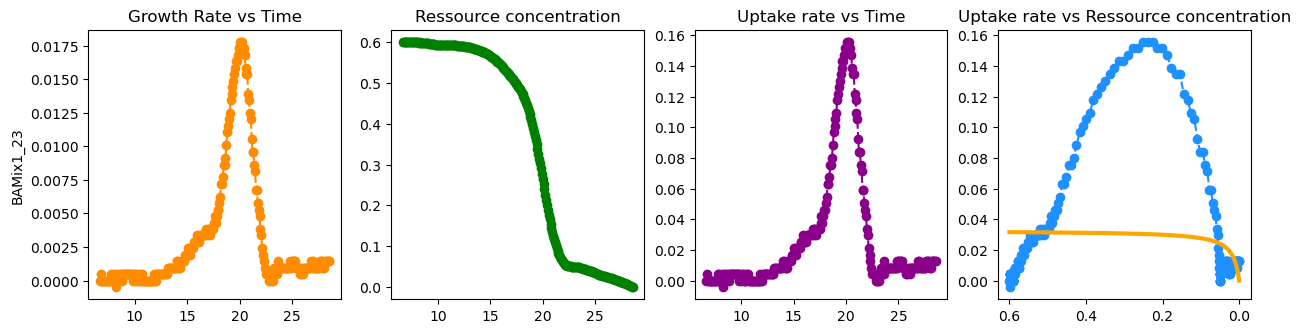

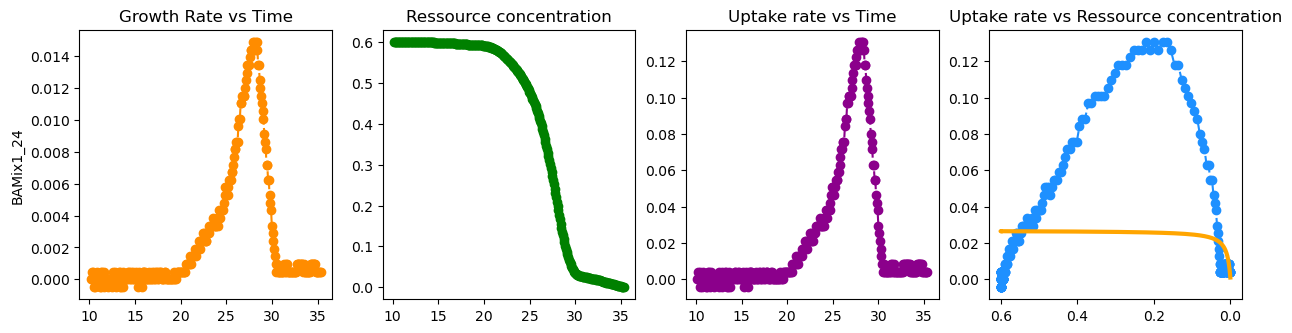

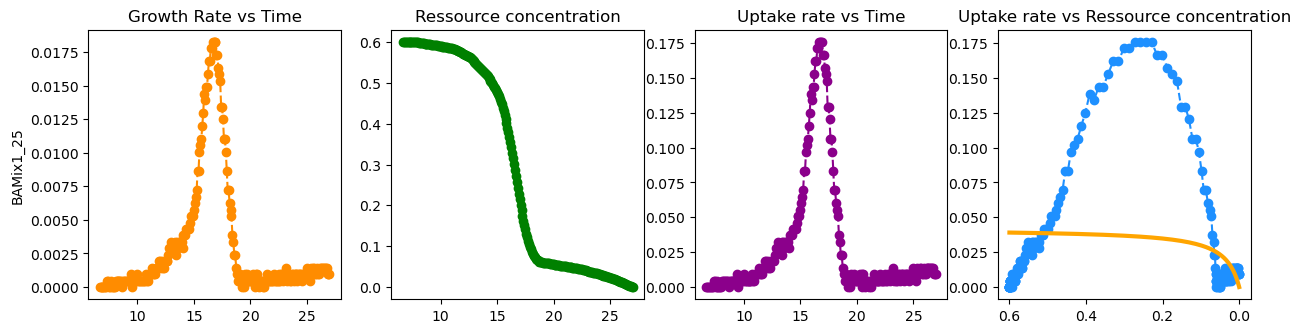

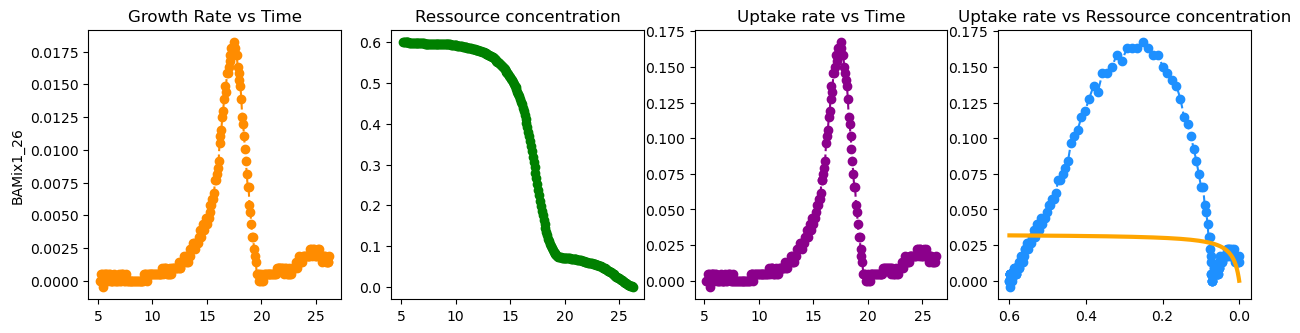

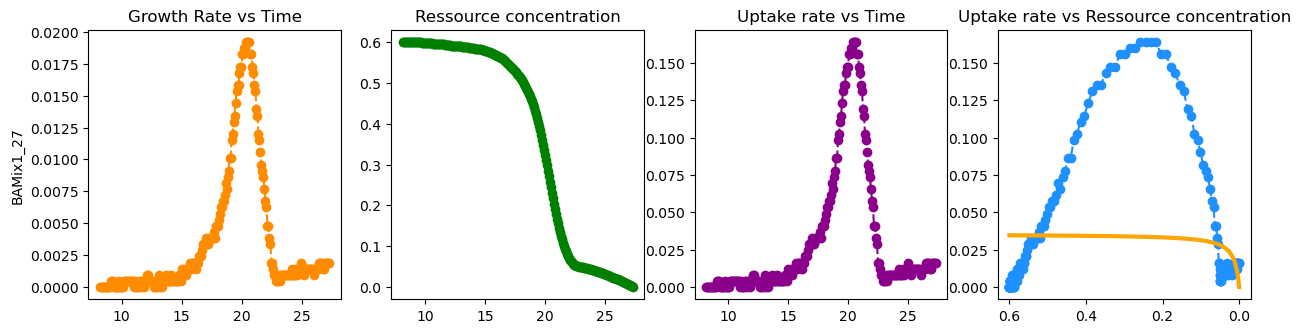

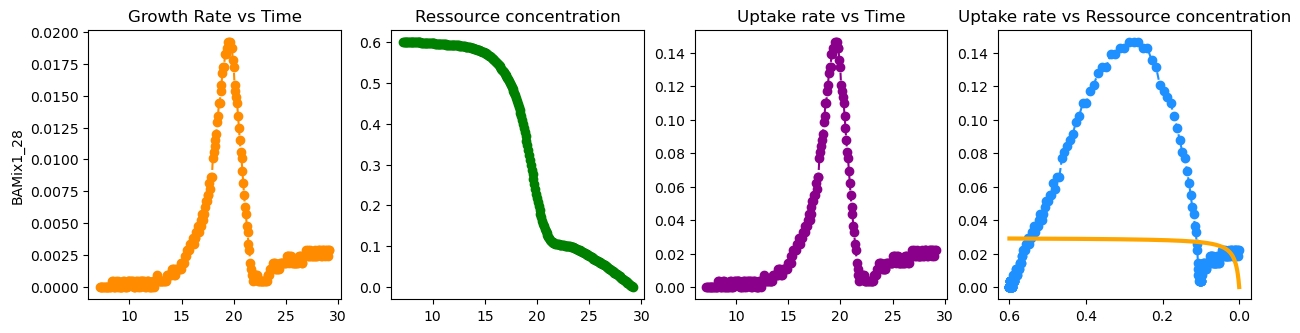

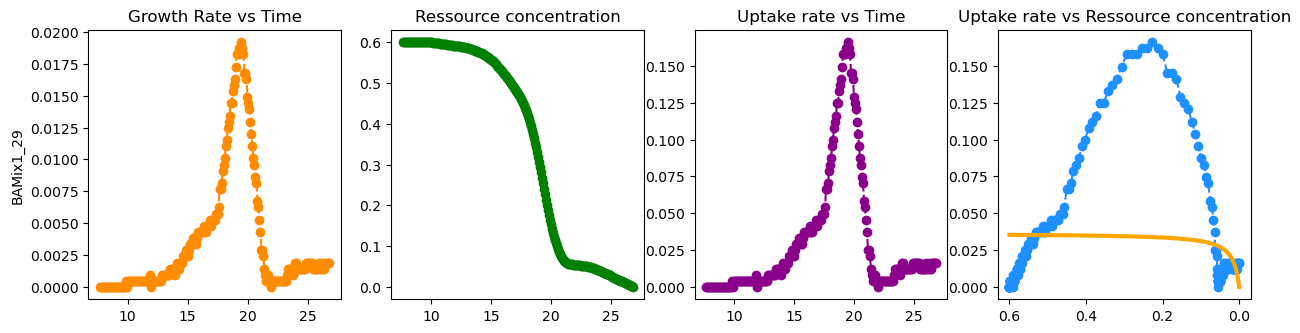

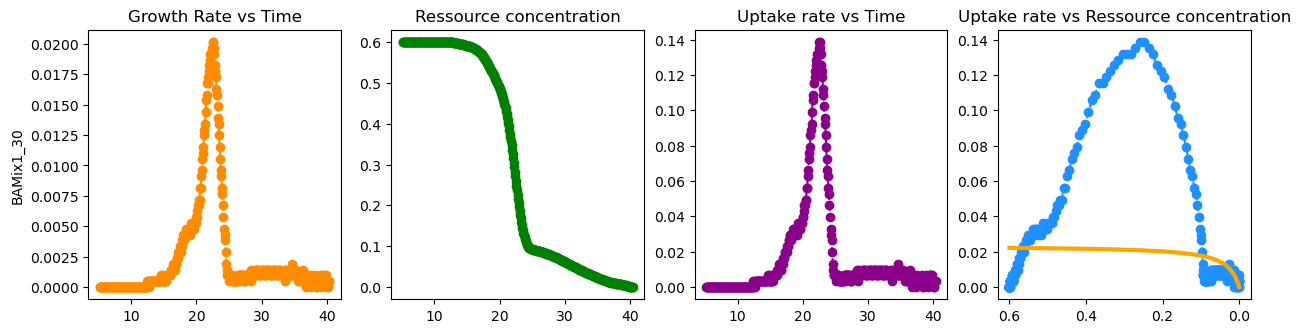

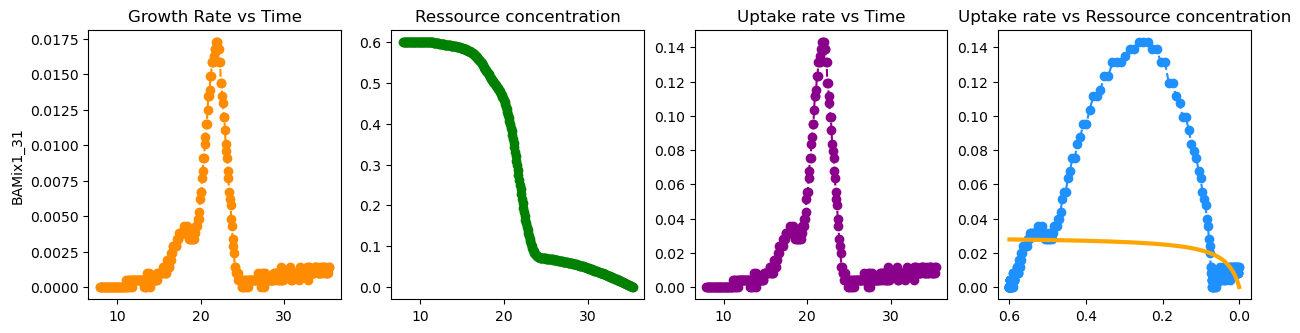

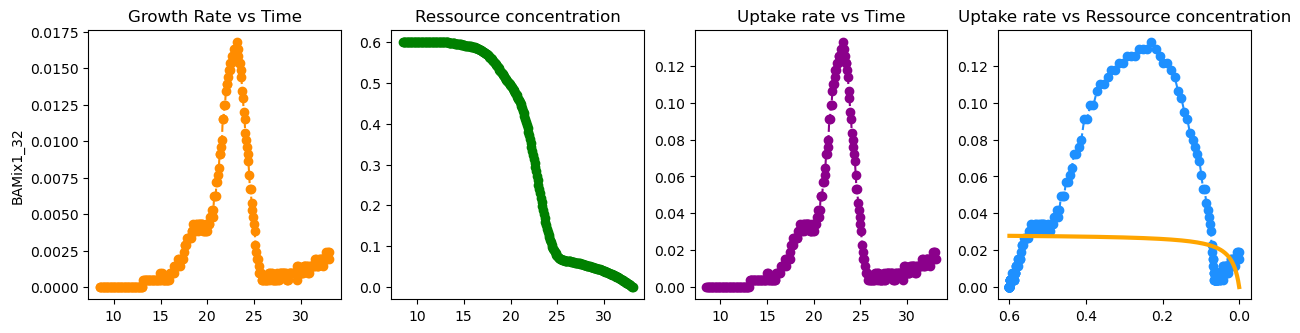

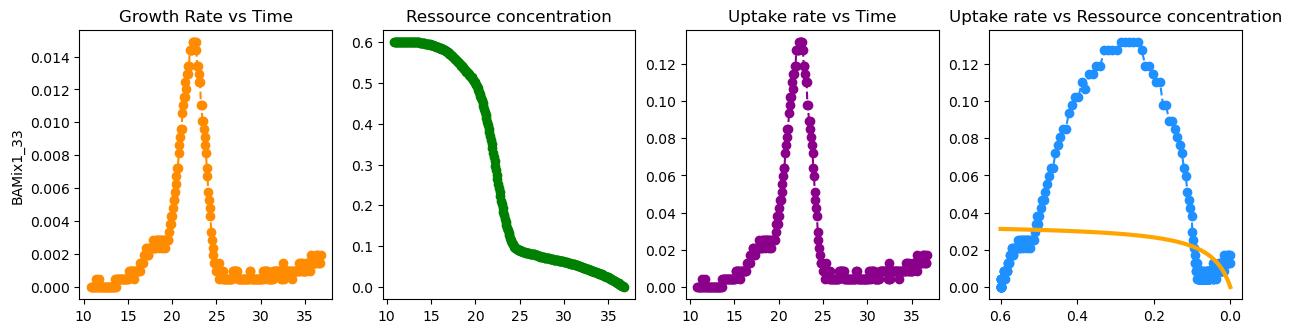

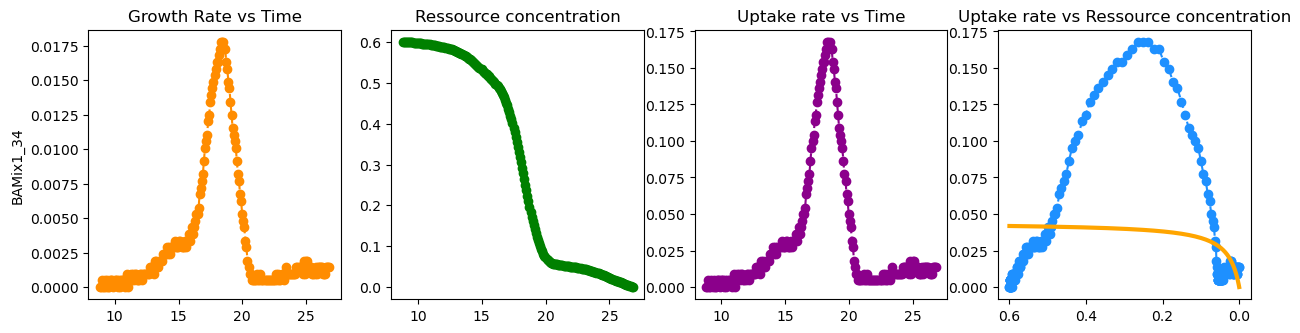

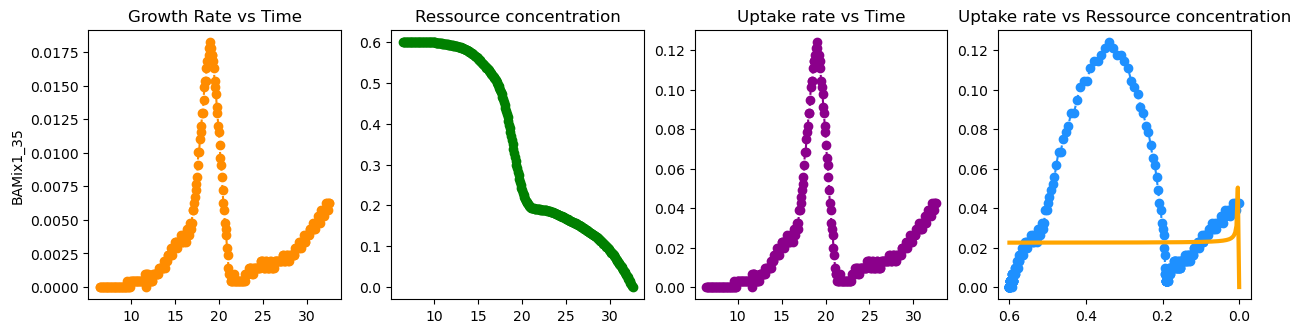

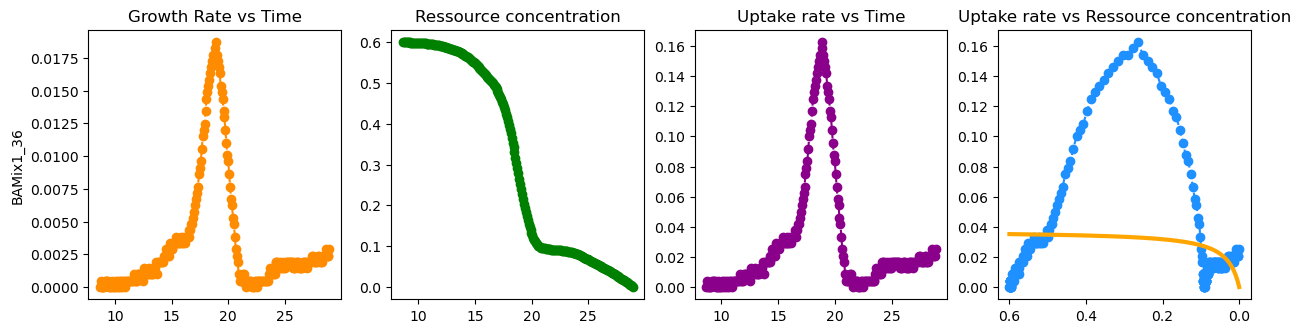

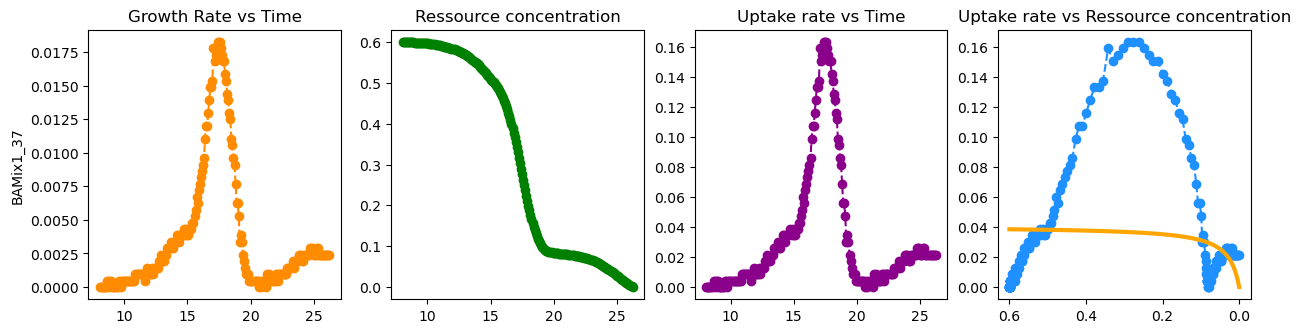

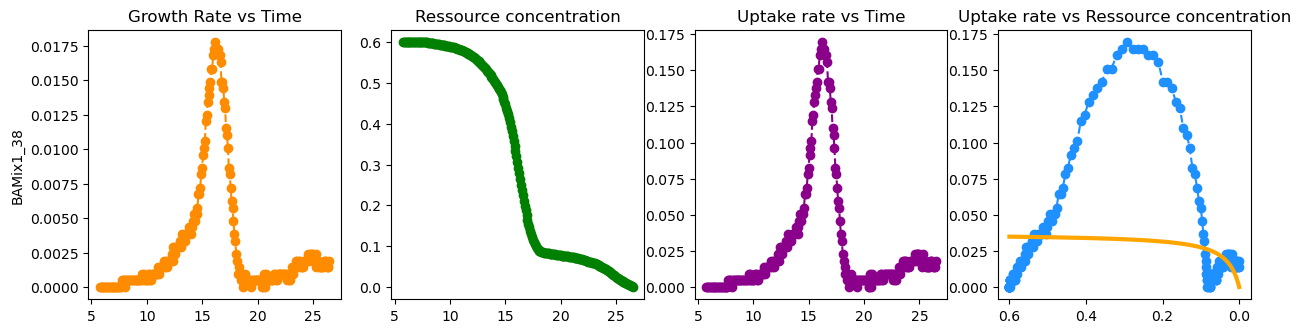

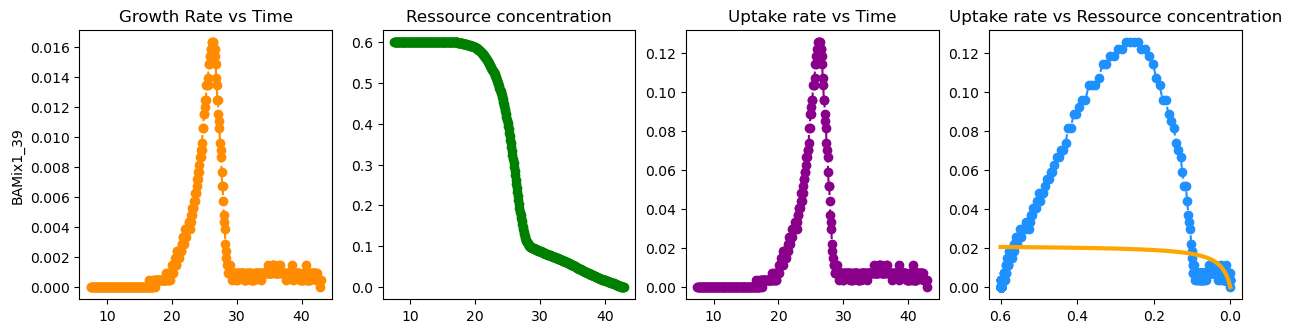

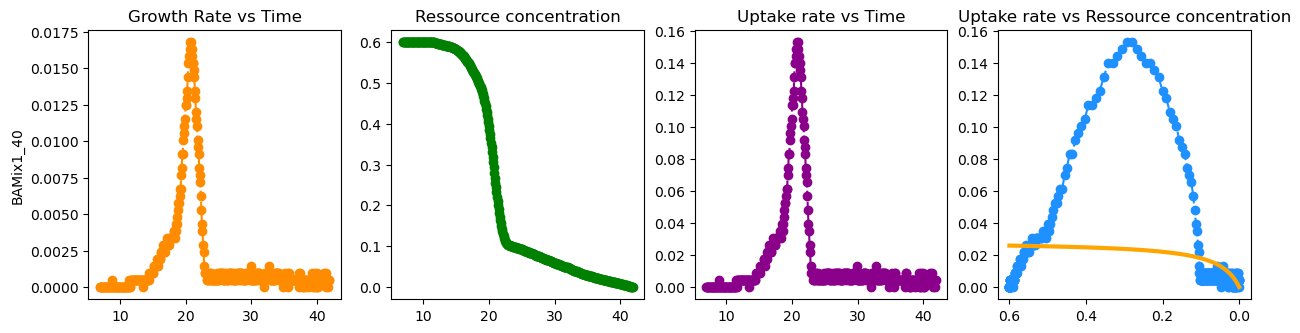

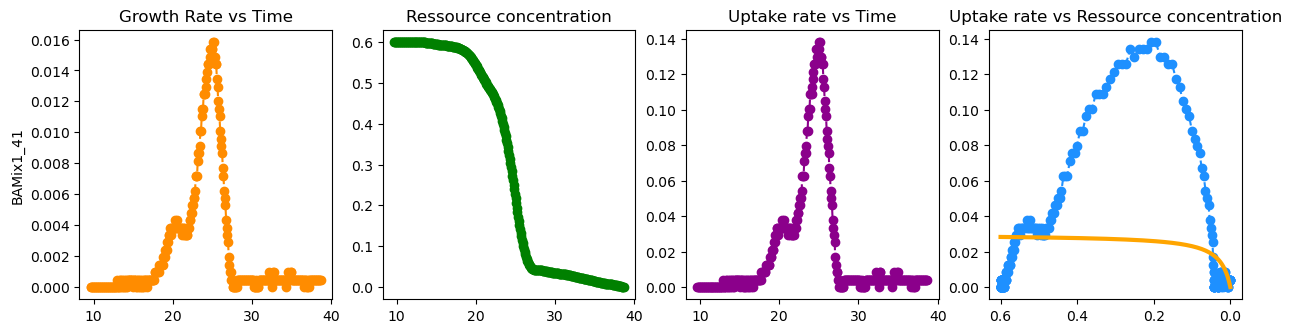

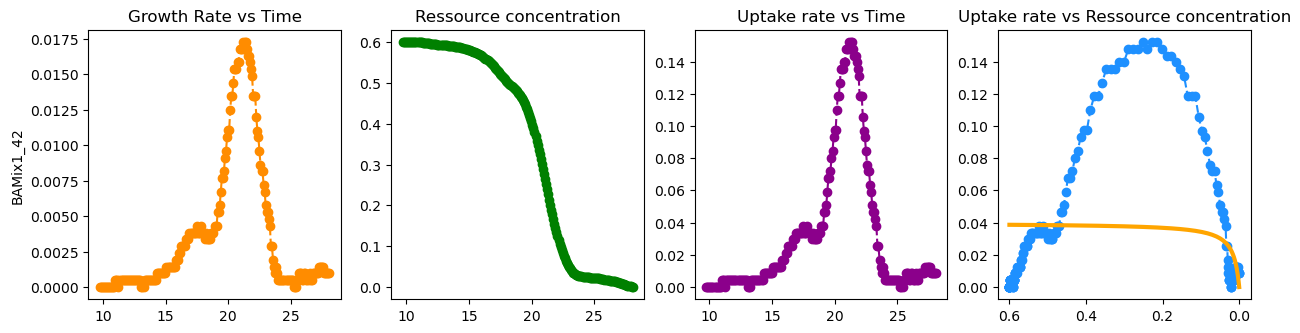

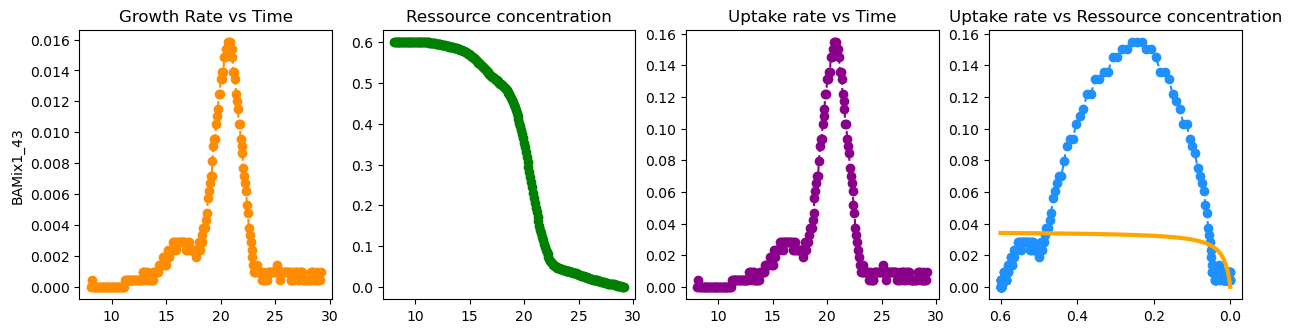

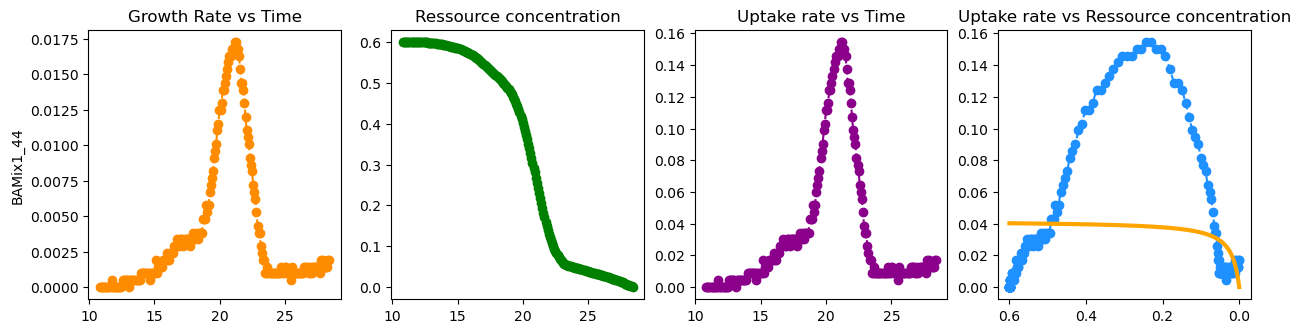

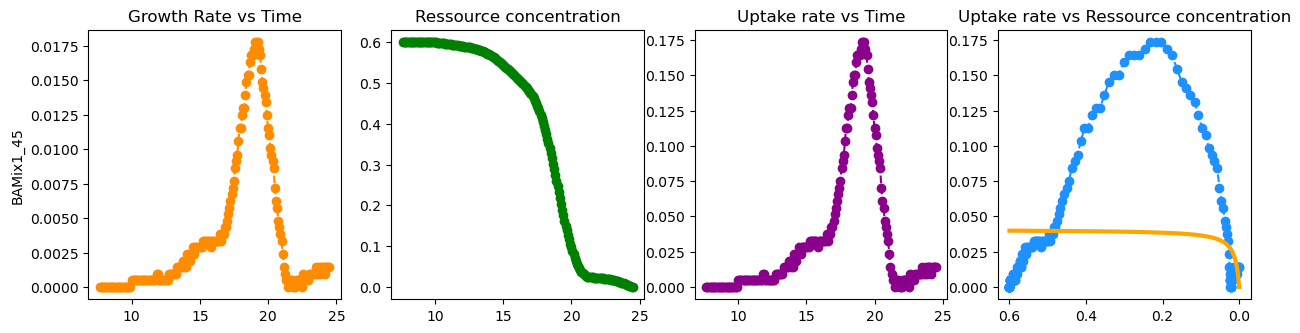

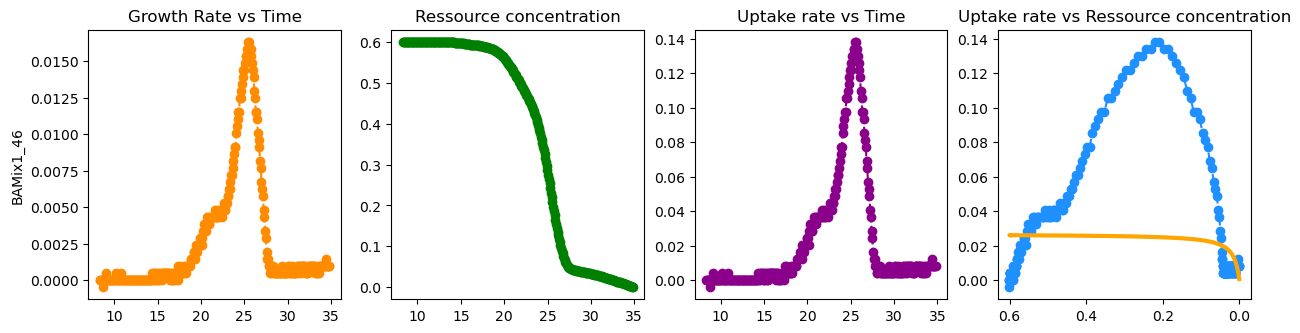

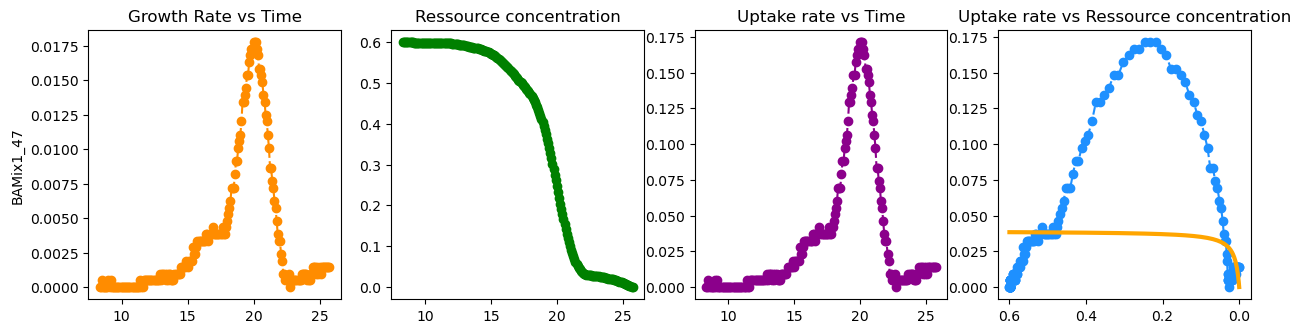

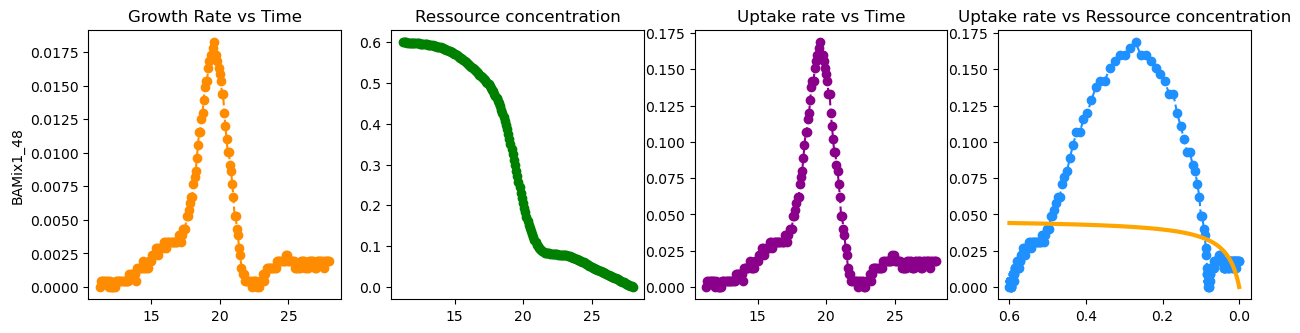

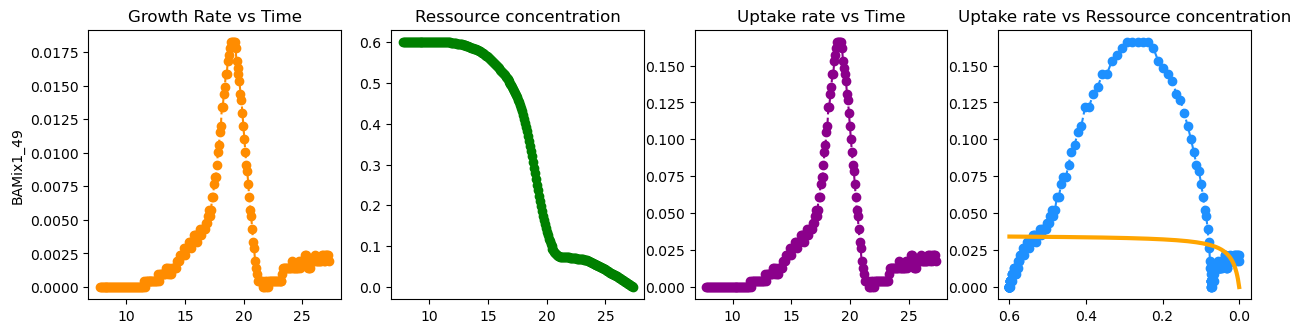

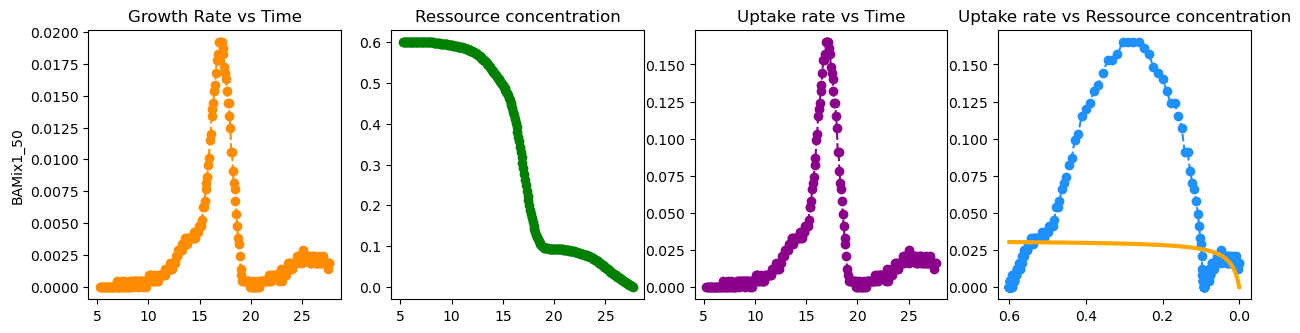

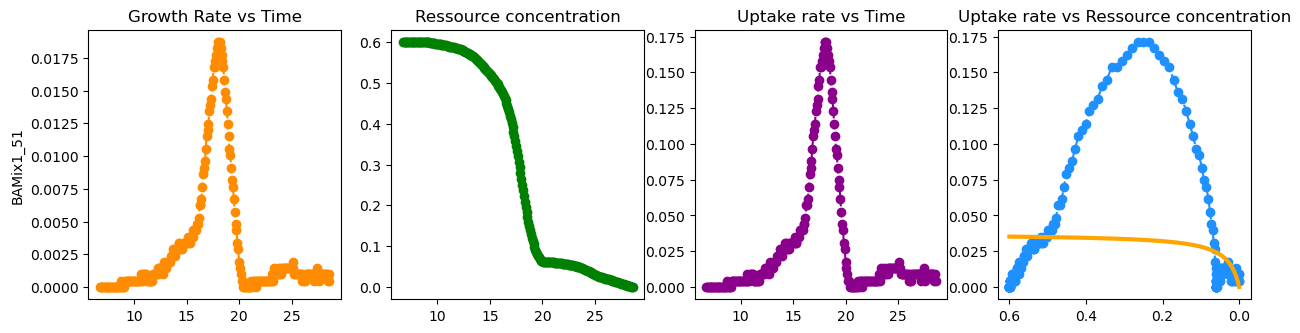

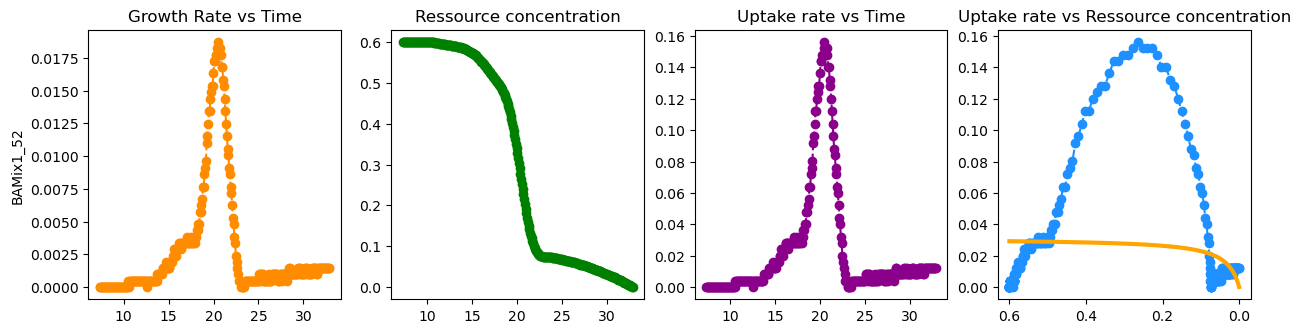

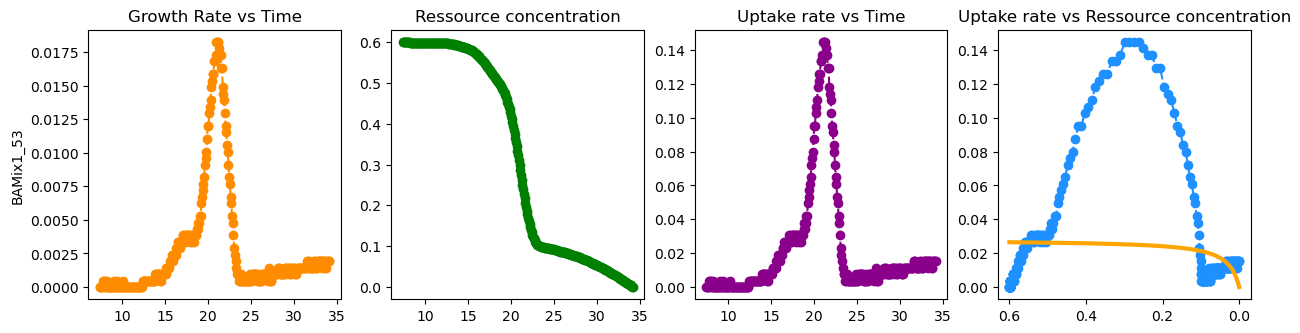

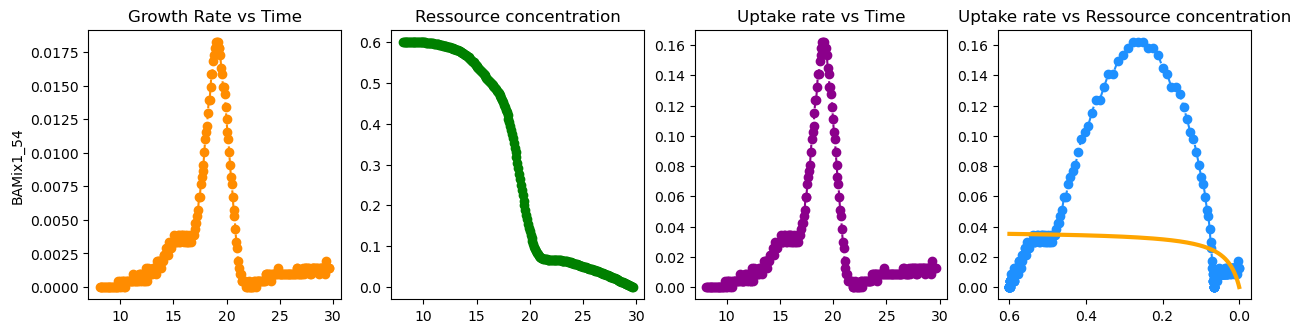

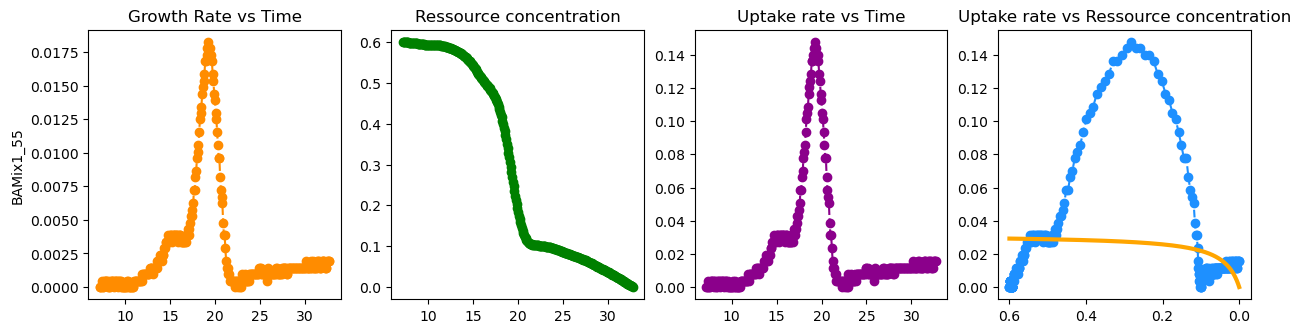

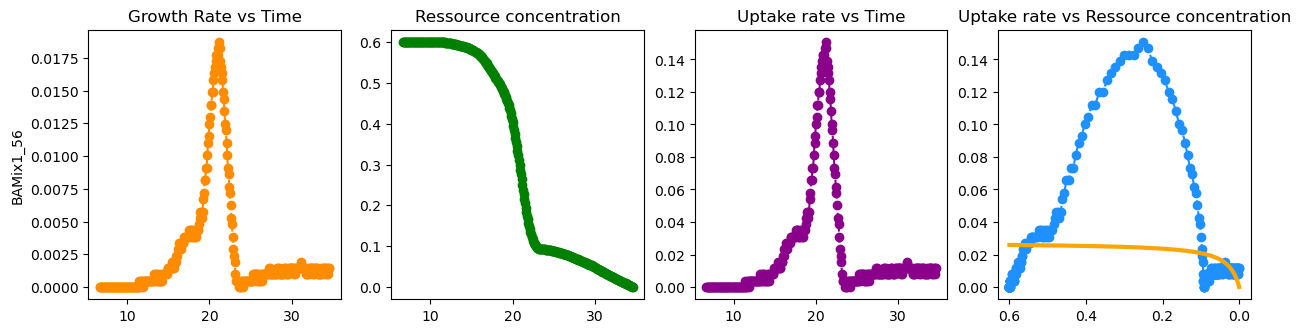

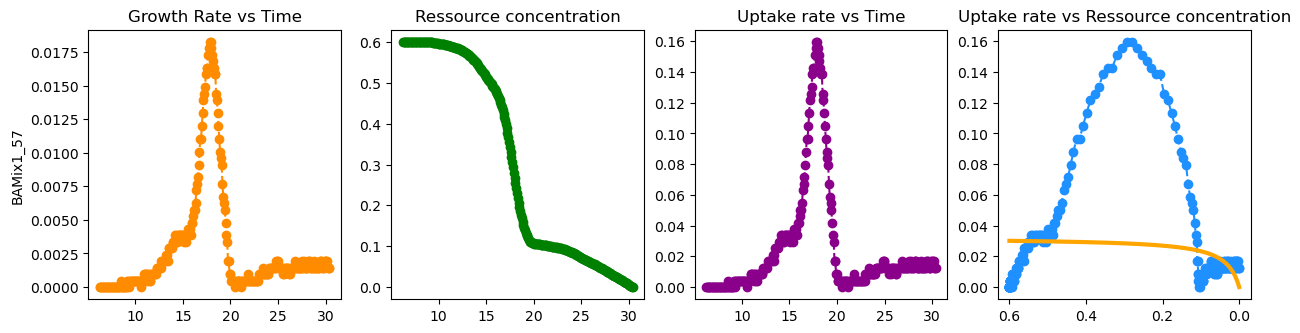

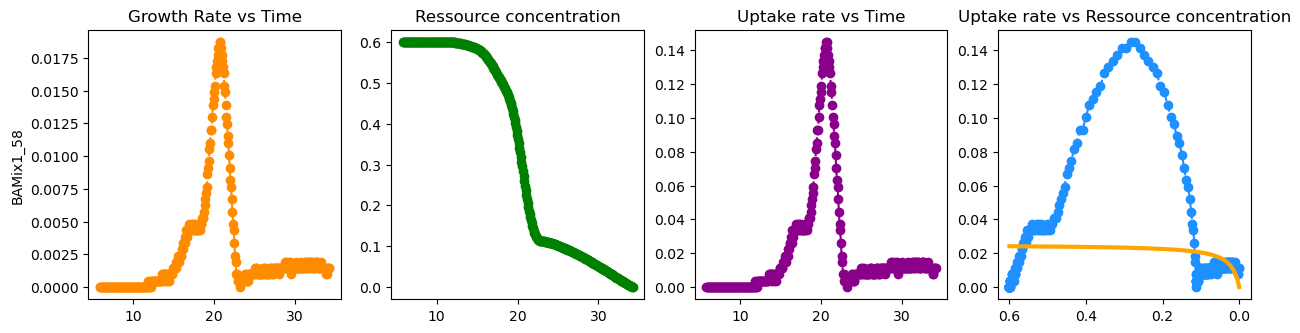

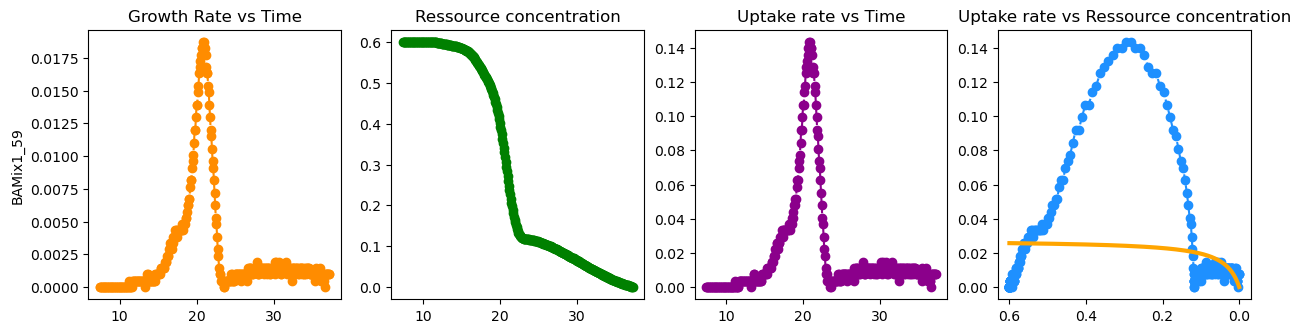

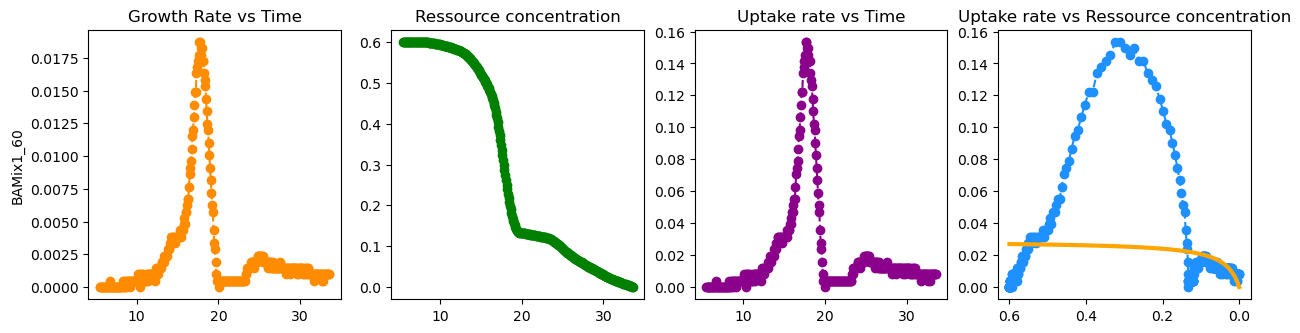

In [194]:
#CALCULATING THE GROWTH PARAMETERS
%matplotlib inline

Condition = []
Final_yield = []
Uptake_rate = []
Max_growth_rate = []
Half_saturation_constant = [] 
Max_uptake_rate = []

for i in Condition_1_dict:
    chosen_key = i
    Condition.append(i)
    # Get the DataFrame corresponding the chosen key
    chosen_df = Condition_1_dict[chosen_key]

    #Calculating final yield (OD max - OD min/Benzoate concentration)
    Benzoate_concentration = 0.6
    chosen_df_max = chosen_df['Smoothed'].max()
    chosen_df_min = chosen_df['Smoothed'].min()
    final_yield = (chosen_df_max - chosen_df_min)/Benzoate_concentration
    Final_yield.append(final_yield)

    #Calculating growth rate and selecting max growth rate
    chosen_df['Growth_Rate'] = np.nan
    Growth_rate = [0]
    
    chosen_df_reset = chosen_df.reset_index(drop=True)
    for x in range(1, len(chosen_df_reset['Smoothed'])):
        initial_value = chosen_df_reset.loc[x - 1,'Smoothed']
        final_value = chosen_df_reset.loc[x,'Smoothed']
        change_in_value = (final_value - initial_value)/(dT/60)
        Growth_rate.append(change_in_value)
    
    chosen_df['Growth_Rate'] = Growth_rate
    Max_growth_rate.append(chosen_df['Growth_Rate'].max())
    
    #Calculating Uptake rate 
    chosen_df['Uptake_Rate'] = np.nan
    Uptake_rate = []
    
    chosen_df_reset = chosen_df.reset_index(drop=True)
    for x in range(0, len(chosen_df_reset['Growth_Rate'])):
        uptake_rate = chosen_df_reset.loc[x,'Growth_Rate']/final_yield
        Uptake_rate.append(uptake_rate)
        
    chosen_df['Uptake_Rate'] = Uptake_rate
    
    #Calculating ressource concentration
    chosen_df['Ressource_Concentration'] = np.nan

    ressource_concentration = [Benzoate_concentration]
    chosen_df_reset = chosen_df.reset_index(drop=True)

    for x in range(1, len(chosen_df_reset['Smoothed'])):
        initial_value = chosen_df_reset.loc[x - 1,'Smoothed']
        final_value = chosen_df_reset.loc[x,'Smoothed']
        ressource_concentration_t = ressource_concentration[x-1]-(final_value-initial_value)/final_yield
        ressource_concentration.append(ressource_concentration_t)

    chosen_df['Ressource_Concentration'] = ressource_concentration

    #Calculating the maximum uptake rate
    chosen_df_clean = chosen_df.dropna(subset=['Ressource_Concentration']).replace([np.inf, -np.inf], np.nan).dropna(subset=['Ressource_Concentration'])

    # Define the Michaelis-Menten model function
    def michaelis_menten(c, Vmax, Km):
        return Vmax * c / (Km + c)
    
    # Initial guess
    initial_guess = [1, 10]
    
    # Fit the model to the data
    params, covariance = curve_fit(michaelis_menten, chosen_df_clean['Ressource_Concentration'], chosen_df_clean['Uptake_Rate'], p0=initial_guess)
    
    # Extract the fitted parameters
    Vmax_fit, Km_fit = params
    Max_uptake_rate.append(Vmax_fit)
    Half_saturation_constant.append(Km_fit)

    #Ploting growth parameters
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 3.5))
    ax1.plot(chosen_df['Time_hours'], chosen_df['Growth_Rate'], color='darkorange', marker='o', linestyle='dashed')
    ax1.set_title('Growth Rate vs Time')
    ax1.set_ylabel(chosen_key)
    
    ax2.plot(chosen_df['Time_hours'], chosen_df['Ressource_Concentration'], color='green', marker='o', linestyle='dashed')
    ax2.set_title('Ressource concentration')

    ax3.plot(chosen_df['Time_hours'], chosen_df['Uptake_Rate'], color='darkmagenta', marker='o', linestyle='dashed')
    ax3.set_title('Uptake rate vs Time')

    ax4.plot(chosen_df['Ressource_Concentration'], chosen_df['Uptake_Rate'], color='dodgerblue', marker='o', linestyle='dashed')
    ax4.plot(chosen_df_clean['Ressource_Concentration'], michaelis_menten(chosen_df_clean['Ressource_Concentration'], *params), color='orange', linewidth=3)
    ax4.invert_xaxis()
    ax4.set_title('Uptake rate vs Ressource concentration')

Result_1 = pd.DataFrame()
Result_1['Condition'] = Condition
Result_1['Yield'] = Final_yield
Result_1['Max Growth Rate'] = Max_growth_rate
Result_1['Half Saturation Constant'] = Half_saturation_constant
Result_1['Max Uptake Rate'] = Max_uptake_rate

file_name = condition_1+'.csv'
file_path = f'{results_output_directory}{file_name}'
Result_1.to_csv(file_path, index=False)
Result_1.head()

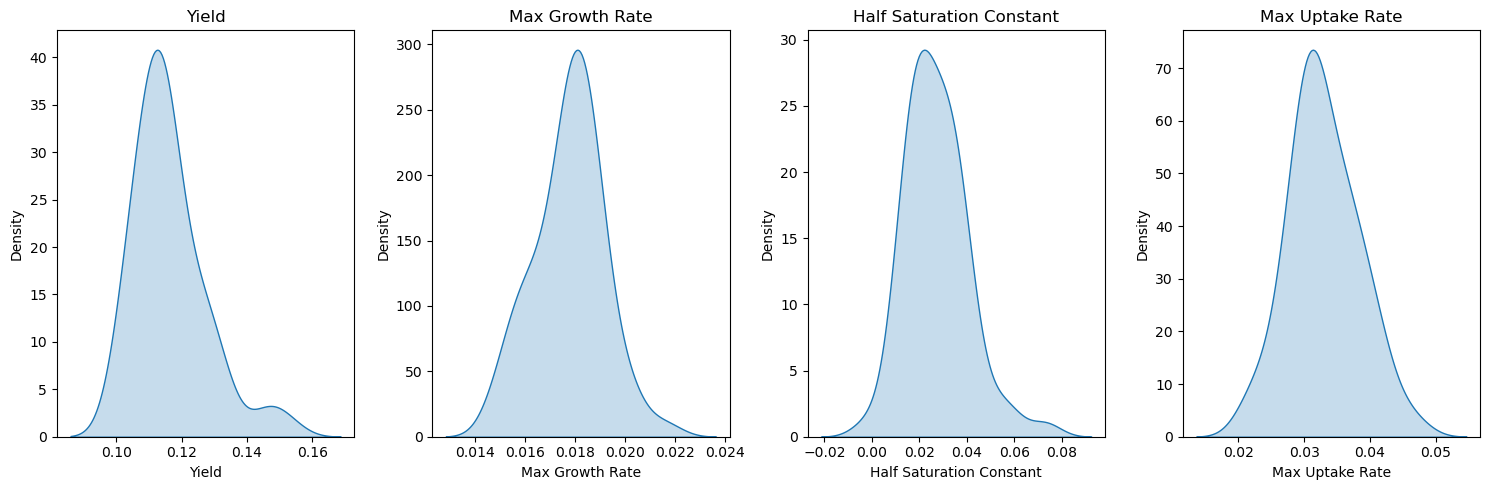

In [195]:
### QUICK VISUALISATION OF THE QUANTIFIACTION
%matplotlib inline

# Set up a 2x1 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

sns.kdeplot(data=Result_1, x="Yield", fill=True, bw=0.5, ax=axes[0])
axes[0].set_title('Yield')

sns.kdeplot(data=Result_1, x="Max Growth Rate", fill=True, bw=0.5, ax=axes[1])
axes[1].set_title('Max Growth Rate')

sns.kdeplot(data=Result_1, x="Half Saturation Constant", fill=True, bw=0.5, ax=axes[2])
axes[2].set_title('Half Saturation Constant')

sns.kdeplot(data=Result_1, x="Max Uptake Rate",  fill=True, bw=0.5, ax=axes[3])
axes[3].set_title('Max Uptake Rate')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()